# Fairness Metrics with Health Expenditures Dataset

#### v1.8
#### DAV-ADS-AG Avoidance of Bias and Discrimination
#### 20.09.2024

---

The integration of datasets containing sensitive variables, such as gender and race, into machine learning projects can lead to biased and discriminatory outcomes. Even removing these protected variables may not entirely eliminate bias and discrimination, as certain features within the dataset may be highly correlated with them, thereby functioning as proxy variables. This notebook aims to investigate the impact on fairness metrics, specifically Demographic Parity and Equalized Odds, by comparing models that incorporate or exclude sensitive variables, as well as those pre-processed using correlation removal techniques applied to the Dataset Health Expenditures by using the Python package Fairlearn (fairlearn.org).

---

#### Table of Contents:

1. Dataimport

2. Descriptive Analysis

3. Binary Classification of COUNTOP (0/>0)

* 3.1 Datapreparation

* 3.2 Splitting the data into training and testing sets

* 3.3 Modelling of COUNTOP1 with GENDER

+ 3.3.1 XGBoost with GENDER

+ 3.3.2 Logistic Regression with GENDER

+ 3.3.3 Random Forest with GENDER

+ 3.3.4 Comparison of metrics for models with GENDER

* 3.4 Modelling of COUNTOP1 without GENDER

+ 3.4.1 XGBoost without GENDER

+ 3.4.2 Logistic Regression without GENDER

+ 3.4.3 Random Forest without GENDER

+ 3.4.4 Comparison of metrics for models without GENDER

* 3.5 Preprocessing with Correlation Remover

+ 3.5.1 Correlation Remover

+ 3.5.2 Splitting the data into training and testing sets with Correlation Remover

+ 3.5.3 XGBoost with Correlation Remover

+ 3.5.4 Logistic Regression with Correlation Remover

+ 3.5.5 Random Forest with Correlation Remover

+ 3.5.6 Comparison of metrics for models with Correlation Remover

* 3.6 Comparison of Metrics for all models

4. Plotting for Metrics Assessment

* 4.1 MetricFrame Visualisation

+ 4.1.1 Logistic Regression with GENDER

+ 4.1.2 Logistic Regression without GENDER

+ 4.1.3 Logistic Regression with Correlation Remover

* 4.2 Model Comparison with Plots of Metrics

5. Fairness Metrics

* 5.1 Demographic Parity and Equalized Odds with GENDER

+ 5.1.1 XGBoost with GENDER

+ 5.1.2 Logistic Regression with GENDER

+ 5.1.3 Random Forest with GENDER

* 5.2 Demographic Parity and Equalized Odds without GENDER

+ 5.2.1 XGBoost without GENDER

+ 5.2.2 Logistic Regression without GENDER

+ 5.2.3 Random Forest without GENDER

* 5.3 Demographic Parity and Equalized Odds with Correlation Remover

+ 5.3.1 XGBoost with Correlation Remover

+ 5.3.2 Logistic Regression mit Correlation Remover

+ 5.3.3 Random Forest with Correlation Remover

* 5.4 Comparison of Fairness Metrics for all models

6. Conclusion

---

#### Import of Libraries

In [1]:
# Import of System Modules
import sys 
print(sys.version) 
import time 

# Ignore unnessesary Warnings 
import warnings 
warnings.filterwarnings('ignore') 

import pandas as pd 
import numpy as np

# Plot Libraries
import matplotlib.pyplot as plt 
plt.rcParams.update({'font.size': 12}) 
import seaborn as sns
from IPython import display

# Matplotlib config 
%matplotlib inline 
%config InlineBackend.figure_formats = ['png']
# Define Figuresize 
%config InlineBackend.rc = {'figure.figsize': (10.0, 6.0)} 
sns.set_style("darkgrid")

from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn import metrics as skmetrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import r2_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from xgboost import plot_importance

# Fairlearn: Correlation Remover and Metrics
from fairlearn.preprocessing import CorrelationRemover
from fairlearn.metrics import (
    MetricFrame,
    count,
    false_negative_rate,
    false_positive_rate,
    selection_rate,
    plot_model_comparison,
    demographic_parity_difference,
    equalized_odds_difference
)

3.11.8 | packaged by conda-forge | (main, Feb 16 2024, 20:53:32) [GCC 12.3.0]


## 1. Dataimport

### Description

The data were from the Medical Expenditure Panel Survey (MEPS), conducted by the
U.S. Agency of Health Research and Quality. MEPS is a probability survey that provides
nationally representative estimates of health care use, expenditures, sources of payment,
and insurance coverage for the U.S. civilian population. This survey collects detailed
information on individuals of each medical care episode by type of services including
physician office visits, hospital emergency room visits, hospital outpatient visits, hospital
inpatient stays, all other medical provider visits, and use of prescribed medicines. This
detailed information allows one to develop models of health care utilization to predict future
expenditures. You can learn more about MEPS at http://www.meps.ahrq.gov/mepsweb/.

We consider MEPS data from the panels 7 and 8 of 2003 that consists of 18,735 individuals
between ages 18 and 65. From this sample, we took a random sample of 2,000 individuals.
From this sample, there are 157 individuals that had positive inpatient expenditures.
There are also 1,352 that had positive outpatient expenditures. We will analyze these
two samples separately. Our dependent variables consist of amounts of expenditures for
inpatient (EXPENDIP) and outpatient (EXPENDOP) visits. For MEPS, outpatient events
include hospital outpatient department visits, office-based provider visits and emergency
room visits excluding dental services. (Dental services, compared to other types of health
care services, are more predictable and occur in a more regular basis.) Hospital stays with
the same date of admission and discharge, known as “zero-night stays”, were included in
outpatient counts and expenditures. (Payments associated with emergency room visits
that immediately preceded an inpatient stay were included in the inpatient expenditures.
Prescribed medicines that can be linked to hospital admissions were included in inpatient
expenditures, not in outpatient utilization.)

### Format

- **AGE**  Age in years between 18 and 65
- **ANYLIMIT**  Any activity limitation (=1 if any functional/activity limitation, =0 if otherwise)
- **COLLEGE**  1 if college or higher degree
- **HIGHSCH**  1 if high school degree
- **GENDER**  Indicate gender of patient (=1 if female, =0 if male)
- **MNHPOOR**  Self-rated mental health (=1 if poor or fair, =0 if good to excellent mental health)
- **insure**  Insurance coverage (=1 if covered by public/private health insurance in any month of 1996, =0 if have no health insurance in 1996)
- **USC**  1 if dissatisfied with one’s usual source of care
- **UNEMPLOY**  Employment status of patients
- **MANAGEDCARE**  1 if enrolled in an HMO or gatekeeper plan
- **famsize**  Family size of patients
- **COUNTIP**  Number of inpatient visits
- **EXPENDIP**  Amounts of expenditures for inpatient visits
- **COUNTOP**  Number of outpatient visits
- **EXPENDOP**  Amounts of expenditures for outpatient visits
- **RACE**  Race of patient described by words (Asian, Black, Native, White and other)
- **RACE1**  Race of patient described by numbers (=1 if Asian, =2 if Black, =3 if Native, =4 if White and =0 if others)
- **REGION**  Region of patient described by words (WEST, NORTHEAST, MIDWEST and SOUTH)
- **REGION1**  Region of patient described by numbers (=0 if WEST, =1 if NORTHEAST, =2 if MIDWEST and =3 if SOUTH)
- **EDUC**  Level of education received described by words (LHIGHSC, HIGHSCH and COLLEGE)
- **EDUC1**  Level of education received described by numbers (=0 if lower than high school, =1 if high school and =2 if college)
- **MARISTAT**  Married status of patients described by words (NEVMAR, MARRIED, WIDOWED and DIVSEP)
- **MARISTAT1**  Married status of patients described by words (=0 if never married, =1 if married, =2 if widowed and =3 if divorced or seperated)
- **INCOME**  Income compared to poverty line described by words (POOR, NPOOR, LINCOME, MINCOME and HINCOME)
- **INCOME1**  Income compared to poverty line described by numbers (=0 if poor, =1 if near poor, =2 if low income, =3 if middle income and =4 if high income)
- **PHSTAT**  Self-rated physical health status described by words (EXCE, VGOO, GOOD, FAIR and POOR)
- **PHSTAT1**  Self-rated physical health status described by numbers (=0 if excellent, =1 if very good, =2 if good, =3 if fair and =4 if poor)
- **INDUSCLASS**  Industry each patient belongs to

In [2]:
df_0 = pd.read_csv("HealthExpend.csv")
df_0

,AGE,ANYLIMIT,COLLEGE,HIGHSCH,GENDER,MNHPOOR,insure,USC,UNEMPLOY,MANAGEDCARE,...,REGION1,EDUC,EDUC1,MARISTAT,MARISTAT1,INCOME,INCOME1,PHSTAT,PHSTAT1,INDUSCLASS
0,30,0,0,0,0,0,0,0,0,0,...,2,LHIGHSC,0,MARRIED,1,MINCOME,3,EXCE,0,TRANSINFO
1,56,1,0,1,0,0,1,1,1,1,...,3,HIGHSCH,1,MARRIED,1,MINCOME,3,GOOD,2,NaN
2,55,1,1,0,0,0,1,1,0,0,...,2,COLLEGE,2,MARRIED,1,HINCOME,4,EXCE,0,NATRESOURCE
3,47,0,1,0,1,0,1,1,0,0,...,1,COLLEGE,2,MARRIED,1,HINCOME,4,FAIR,3,NaN
4,50,0,1,0,1,0,1,1,1,1,...,0,COLLEGE,2,DIVSEP,3,LINCOME,2,GOOD,2,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,44,1,1,0,0,0,0,1,0,0,...,0,COLLEGE,2,NEVMAR,0,POOR,0,EXCE,0,NaN
1996,23,0,0,1,1,0,0,0,0,0,...,0,HIGHSCH,1,NEVMAR,0,MINCOME,3,GOOD,2,SALES
1997,34,1,0,0,0,1,0,0,0,0,...,2,LHIGHSC,0,NEVMAR,0,NPOOR,1,FAIR,3,NaN
1998,65,1,0,0,0,0,1,1,1,0,...,3,LHIGHSC,0,MARRIED,1,LINCOME,2,FAIR,3,NaN


### Observations:

- The dataset contain the protected variables **Gender** und **RACE/RACE1**.
- Probably some other variables can serve as proxy-variables for the protected variables.

---

## 2. Descriptive Analysis

In [3]:
df_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   AGE          2000 non-null   int64  
 1   ANYLIMIT     2000 non-null   int64  
 2   COLLEGE      2000 non-null   int64  
 3   HIGHSCH      2000 non-null   int64  
 4   GENDER       2000 non-null   int64  
 5   MNHPOOR      2000 non-null   int64  
 6   insure       2000 non-null   int64  
 7   USC          2000 non-null   int64  
 8   UNEMPLOY     2000 non-null   int64  
 9   MANAGEDCARE  2000 non-null   int64  
 10  famsize      2000 non-null   int64  
 11  COUNTIP      2000 non-null   int64  
 12  EXPENDIP     2000 non-null   float64
 13  COUNTOP      2000 non-null   int64  
 14  EXPENDOP     2000 non-null   float64
 15  RACE         2000 non-null   object 
 16  RACE1        2000 non-null   int64  
 17  REGION       2000 non-null   object 
 18  REGION1      2000 non-null   int64  
 19  EDUC  

Only INDUSCLASS contains Missing Values.

In [4]:
df_0.describe()

,AGE,ANYLIMIT,COLLEGE,HIGHSCH,GENDER,MNHPOOR,insure,USC,UNEMPLOY,MANAGEDCARE,...,COUNTIP,EXPENDIP,COUNTOP,EXPENDOP,RACE1,REGION1,EDUC1,MARISTAT1,INCOME1,PHSTAT1
count,2000.00000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,39.03450,0.223000,0.272000,0.433000,0.527000,0.074500,0.777500,0.687500,0.226500,0.590500,...,0.101500,1008.282620,5.674500,1253.026185,3.49900,1.682000,0.977000,0.982000,2.534000,1.354500
std,12.99087,0.416362,0.445101,0.495615,0.499395,0.262649,0.416029,0.463628,0.418671,0.491865,...,0.418671,14073.575726,12.500027,3293.237418,1.00075,1.240421,0.752831,0.905586,1.419455,1.076759
min,18.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,4.00000,0.000000,0.000000,0.000000,2.000000,0.000000
50%,39.00000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,2.000000,219.250000,4.00000,2.000000,1.000000,1.000000,3.000000,1.000000
75%,49.00000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,6.000000,1152.830000,4.00000,3.000000,2.000000,1.000000,4.000000,2.000000
max,65.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,7.000000,607800.560000,167.000000,62811.070000,4.00000,3.000000,2.000000,3.000000,4.000000,4.000000


Upon examining the statistics for all features, it becomes apparent that the maximum value in EXPENDIP is significantly higher than the other values in this column. This suggests the presence of a possible outlier. Furthermore, the calculation of the z-score, which is often used for outlier analysis, yields a value of 43. This value is clearly above the commonly accepted threshold of 3.

In [5]:
# Calculation of Z-Scores
df_0['Z-Score'] = (df_0['EXPENDIP'] - df_0['EXPENDIP'].mean()) / df_0['EXPENDIP'].std()

outlier = df_0[np.abs(df_0['Z-Score']) > 3]
print(outlier)

      AGE  ANYLIMIT  COLLEGE  HIGHSCH  GENDER  MNHPOOR  insure  USC  UNEMPLOY  \
171    49         1        1        0       1        0       1    1         0   
732    19         1        0        0       0        0       1    1         1   
911    33         0        0        1       1        0       1    1         0   
1828   60         1        0        1       1        0       1    1         1   

      MANAGEDCARE  ...     EDUC  EDUC1  MARISTAT  MARISTAT1   INCOME INCOME1  \
171             0  ...  COLLEGE      2    DIVSEP          3  LINCOME       2   
732             1  ...  LHIGHSC      0    NEVMAR          0  MINCOME       3   
911             1  ...  HIGHSCH      1    DIVSEP          3  LINCOME       2   
1828            1  ...  HIGHSCH      1   MARRIED          1  MINCOME       3   

      PHSTAT PHSTAT1  INDUSCLASS    Z-Score  
171     GOOD       2       SALES   3.284177  
732     GOOD       2         NaN  43.115715  
911     VGOO       1       SALES   3.315606  
1828    V

The handling of outliers is an important component of data analysis. Here it's advisable to take a closer look at the feature and potentially remove it. Another possibility (especially in this case, as it involves a possible target variable) is to cap large values and divide them among the other values.

Now, categorical features are defined as such.

In [6]:
df_1 = df_0.drop('Z-Score', axis=1)

for col in ['RACE', 'REGION', 'EDUC', 'MARISTAT', 'INCOME', 'PHSTAT', 'INDUSCLASS']:
    df_1[col] = df_1[col].astype('category')

Subsequently, a first correlation analysis is conducted for the numerical features.

In [7]:
df_2 = df_1.drop(['RACE', 'REGION', 'EDUC', 'MARISTAT', 'INCOME', 'PHSTAT', 'INDUSCLASS'], axis=1)
corr = df_2.corr()
corr.style.background_gradient(cmap='coolwarm')

,AGE,ANYLIMIT,COLLEGE,HIGHSCH,GENDER,MNHPOOR,insure,USC,UNEMPLOY,MANAGEDCARE,famsize,COUNTIP,EXPENDIP,COUNTOP,EXPENDOP,RACE1,REGION1,EDUC1,MARISTAT1,INCOME1,PHSTAT1
AGE,1.000000,0.255966,0.086189,-0.020036,-0.015373,0.058038,0.158589,0.239252,0.126042,0.053570,-0.235907,0.046264,-0.004695,0.154602,0.194085,0.033691,0.056685,0.088725,0.386880,0.167740,0.167961
ANYLIMIT,0.255966,1.000000,-0.079123,0.016683,0.009522,0.255132,0.084430,0.140911,0.252483,0.003999,-0.203617,0.145585,0.078317,0.314419,0.258848,-0.017473,0.059887,-0.082577,0.128731,-0.089861,0.320123
COLLEGE,0.086189,-0.079123,1.000000,-0.534160,-0.026304,-0.096400,0.218929,0.157569,-0.158962,0.209688,-0.145206,-0.022055,-0.019354,0.051616,0.030810,0.030934,-0.011786,0.830817,0.000983,0.339283,-0.186678
HIGHSCH,-0.020036,0.016683,-0.534160,1.000000,0.025503,-0.032731,0.035628,0.001361,-0.048576,0.007443,-0.046274,-0.006989,-0.016522,-0.006631,-0.008175,-0.040479,0.021472,0.026705,0.046353,0.043060,-0.022495
GENDER,-0.015373,0.009522,-0.026304,0.025503,1.000000,0.043772,0.061435,0.149891,0.199229,0.039943,-0.015599,0.079001,-0.009309,0.107790,0.053924,-0.032978,0.050207,-0.014315,0.099522,-0.104328,0.084059
MNHPOOR,0.058038,0.255132,-0.096400,-0.032731,0.043772,1.000000,-0.003880,0.018743,0.233156,-0.085130,-0.032453,0.099522,0.017733,0.171036,0.130894,-0.027313,0.055864,-0.135538,0.056118,-0.184587,0.354090
insure,0.158589,0.084430,0.218929,0.035628,0.061435,-0.003880,1.000000,0.347373,-0.052293,0.642389,-0.162489,0.089514,0.034348,0.121413,0.131268,-0.005942,-0.005341,0.282333,0.050443,0.309730,-0.069513
USC,0.239252,0.140911,0.157569,0.001361,0.149891,0.018743,0.347373,1.000000,0.063302,0.237054,-0.118821,0.075866,0.032870,0.173981,0.171906,0.026820,0.046320,0.187217,0.086680,0.173123,0.031628
UNEMPLOY,0.126042,0.252483,-0.158962,-0.048576,0.199229,0.233156,-0.052293,0.063302,1.000000,-0.142102,0.045318,0.142754,0.067047,0.139602,0.127660,-0.023935,-0.011507,-0.219948,0.017356,-0.323998,0.225721
MANAGEDCARE,0.053570,0.003999,0.209688,0.007443,0.039943,-0.085130,0.642389,0.237054,-0.142102,1.000000,-0.086754,0.039180,0.028521,0.047550,0.049211,-0.002357,-0.065956,0.252851,0.010398,0.314078,-0.115862


As an intermediate conclusion, it can be noted that in the dataset there are no very high correlations with other variables concerning Gender and Race. The highest correlation with the feature GENDER is present for the feature UNEMPLOY (0.2).

Additionally, a density plot of age by sex does not show any significant differences.

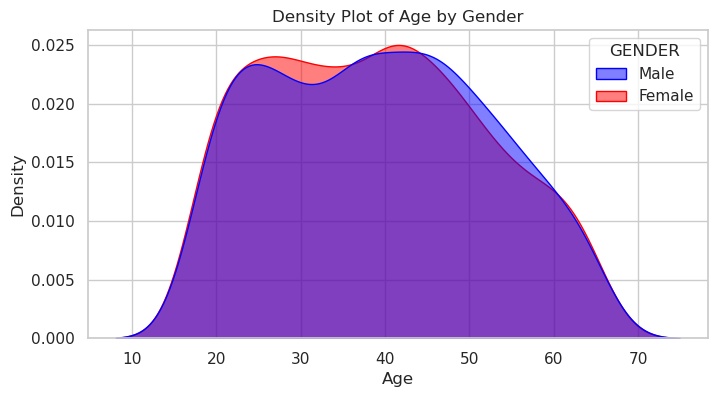

In [8]:

sns.set(style="whitegrid")

df_1['GENDER'] = df_1['GENDER'].map({0: 'Male', 1: 'Female'})

plt.figure(figsize=(8, 4))
sns.kdeplot(data=df_1, x='AGE', hue='GENDER', fill=True, common_norm=False, palette={"Male": "blue", "Female": "red"}, alpha=0.5)

# Add title and labels
plt.title('Density Plot of Age by Gender')
plt.xlabel('Age')
plt.ylabel('Density')

# Show the plot
plt.show()

---

## 3. Binary Classification of COUNTOP (0/>0)

After an initial general data analysis, various models will now be created. We start with a binary classification of the feature COUNTOP. To do this, the feature needs to be prepared.

### 3.1 Datapreparation

The numerical feature COUNTOP is converted to a binary variable (incident vs no incident).

In [9]:
## Data preparation and creation of the target variable COUNTOP1
df_3 = df_2.copy()
df_3['COUNTOP1'] = np.where(df_3.COUNTOP == 0, 0, 1)
df_3 = df_3.drop(['COUNTIP', 'EXPENDIP', 'COUNTOP', 'EXPENDOP'], axis=1)

### 3.2 Splitting the data into training and testing sets

When splitting the data into training and testing sets, we use a 70/30 split. Of course, other partitioning or cross-validation approaches are also possible.

In [10]:
# Training and Testing Set
X = df_3.drop(['COUNTOP1'],axis=1)
y = df_3.COUNTOP1
# train and test split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [11]:
# Target Distribution in the Training and Testing Set
Target_Dist_Train = y_train.value_counts(normalize=True).to_frame()
Target_Dist_Test  = y_test.value_counts(normalize=True).to_frame()

print("Distribution COUNTOP1 training set: ")
print(Target_Dist_Train)
print("Distribution COUNTOP1 testing set: ")
print(Target_Dist_Test)

Distribution COUNTOP1 training set: 
          proportion
COUNTOP1            
1           0.668571
0           0.331429
Distribution COUNTOP1 testing set: 
          proportion
COUNTOP1            
1           0.693333
0           0.306667


In [12]:
# Target Distribution in the Training and Testing Set per GENDER
# Concatenate the train data with the predictions
df_train = pd.DataFrame(X_train)
df_train['COUNTOP1'] = y_train
Target_Dist_Train_M = df_train[df_train['GENDER'] == 0]['COUNTOP1'].value_counts(normalize=True).to_frame()
Target_Dist_Train_F = df_train[df_train['GENDER'] == 1]['COUNTOP1'].value_counts(normalize=True).to_frame()

print("Distribution COUNTOP1 training set for Male: ")
print(Target_Dist_Train_M)
print("Distribution COUNTOP1 training set for Female: ")
print(Target_Dist_Train_F)

# Concatenate the test data with the predictions
df_test = pd.DataFrame(X_test)
df_test['COUNTOP1'] = y_test
Target_Dist_Test_M = df_test[df_test['GENDER'] == 0]['COUNTOP1'].value_counts(normalize=True).to_frame()
Target_Dist_Test_F = df_test[df_test['GENDER'] == 1]['COUNTOP1'].value_counts(normalize=True).to_frame()

print("Distribution COUNTOP1 testing set for Male: ")
print(Target_Dist_Test_M)
print("Distribution COUNTOP1 testing set for Female: ")
print(Target_Dist_Test_F)

Distribution COUNTOP1 training set for Male: 
          proportion
COUNTOP1            
1            0.56305
0            0.43695
Distribution COUNTOP1 training set for Female: 
          proportion
COUNTOP1            
1           0.768802
0           0.231198
Distribution COUNTOP1 testing set for Male: 
          proportion
COUNTOP1            
1           0.583333
0           0.416667
Distribution COUNTOP1 testing set for Female: 
          proportion
COUNTOP1            
1           0.779762
0           0.220238


### 3.3 Modelling of COUNTOP1 with GENDER

To investigate the influence of GENDER on the Bias, we commence by modelling the relationship between COUNTOP1 and all the features incl. GENDER, serving as our initial analysis.

#### 3.3.1 XGBoost with GENDER

As our initial model, we employ a classical XGBoost model with default settings. Following this, we report the performance metrics (accuracy, precision, and recall) as well as generate feature importance rankings.

In [13]:
# Modelling
model_xgb = xgb.XGBClassifier(random_state = 42)
model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [14]:
# Prediction
y_pred_xgb = model_xgb.predict(X_test)
y_pred_prob_xgb = model_xgb.predict_proba(X_test)

In [15]:
# Target Distribution in the Training and Testing Set per GENDER
# Concatenate the test data with the predictions
df_test_xgb = pd.DataFrame(X_test)
df_test_xgb['COUNTOP1'] = y_pred_xgb
Target_Dist_Test_M_xgb = df_test_xgb[df_test_xgb['GENDER'] == 0]['COUNTOP1'].value_counts(normalize=True).to_frame()
Target_Dist_Test_F_xgb = df_test_xgb[df_test_xgb['GENDER'] == 1]['COUNTOP1'].value_counts(normalize=True).to_frame()

print("Distribution COUNTOP1 testing set for Male: ")
print(Target_Dist_Test_M_xgb)
print("Distribution COUNTOP1 testing set for Female: ")
print(Target_Dist_Test_F_xgb)

Distribution COUNTOP1 testing set for Male: 
          proportion
COUNTOP1            
1           0.575758
0           0.424242
Distribution COUNTOP1 testing set for Female: 
          proportion
COUNTOP1            
1           0.833333
0           0.166667


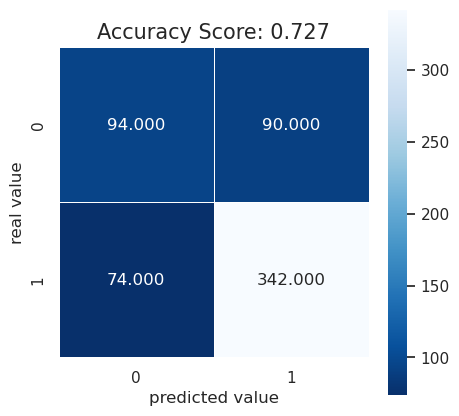

In [16]:
# Accuracy Score
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
# Confusion Matrix 
cm = skmetrics.confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('real value');
plt.xlabel('predicted value');
all_sample_title = 'Accuracy Score: {0}'.format(round(accuracy_xgb,3))
plt.title(all_sample_title, size = 15);

In [17]:
# Metrics
print('Accuracy Score: {0}'.format(round(accuracy_xgb,3)))
precision_xgb = precision_score(y_test, y_pred_xgb)
print('Precision Score: {0}'.format(round(precision_xgb,3)))
recall_xgb = recall_score(y_test, y_pred_xgb)
print('Recall Score: {0}'.format(round(recall_xgb,3)))
auc_xgb = roc_auc_score(y_test,y_pred_prob_xgb[:,1])
print('Computed AUC: {0}'.format(round(auc_xgb,3)))
tpr_xgb = recall_xgb
tnr_xgb = recall_score(y_test, y_pred_xgb, pos_label=0)
fpr_xgb = 1 - tnr_xgb
fnr_xgb = 1 - tpr_xgb
print('False Positive Rate: {0}'.format(round(fpr_xgb,3)))
print('False Negative Rate: {0}'.format(round(fnr_xgb,3)))

Accuracy Score: 0.727
Precision Score: 0.792
Recall Score: 0.822
Computed AUC: 0.736
False Positive Rate: 0.489
False Negative Rate: 0.178


In [18]:
# Metrics per GENDER
df_test_xgb = pd.DataFrame(X_test)
df_test_xgb['COUNTOP1'] = y_test
df_test_xgb['y_pred_xgb'] = y_pred_xgb

tpr_m_xgb = recall_score(df_test_xgb[df_test_xgb['GENDER']==0]['COUNTOP1'],\
                         df_test_xgb[df_test_xgb['GENDER']==0]['y_pred_xgb'])
tnr_m_xgb = recall_score(df_test_xgb[df_test_xgb['GENDER']==0]['COUNTOP1'],\
                         df_test_xgb[df_test_xgb['GENDER']==0]['y_pred_xgb'],pos_label=0)
fpr_m_xgb = 1 - tnr_m_xgb
fnr_m_xgb = 1 - tpr_m_xgb
print('False Positive Rate for Males: {0}'.format(round(fpr_m_xgb,3)))
print('False Negative Rate for Males: {0}'.format(round(fnr_m_xgb,3)))

tpr_f_xgb = recall_score(df_test_xgb[df_test_xgb['GENDER']==1]['COUNTOP1'],\
                         df_test_xgb[df_test_xgb['GENDER']==1]['y_pred_xgb'])
tnr_f_xgb = recall_score(df_test_xgb[df_test_xgb['GENDER']==1]['COUNTOP1'],\
                         df_test_xgb[df_test_xgb['GENDER']==1]['y_pred_xgb'],pos_label=0)
fpr_f_xgb = 1 - tnr_f_xgb
fnr_f_xgb = 1 - tpr_f_xgb
print('False Positive Rate for Females: {0}'.format(round(fpr_f_xgb,3)))
print('False Negative Rate for Females: {0}'.format(round(fnr_f_xgb,3)))

False Positive Rate for Males: 0.327
False Negative Rate for Males: 0.247
False Positive Rate for Females: 0.73
False Negative Rate for Females: 0.137


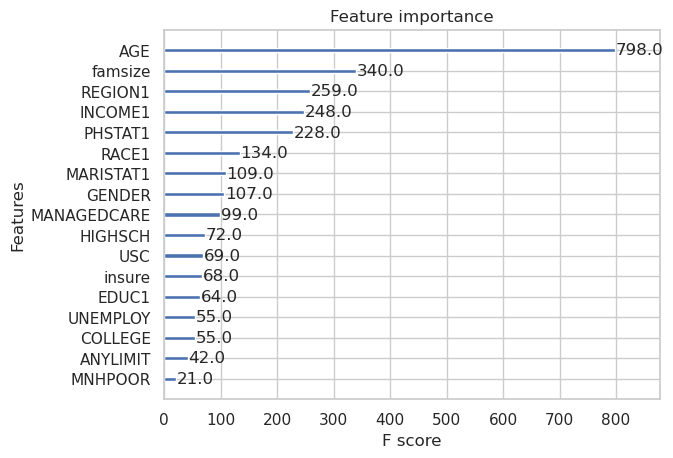

In [19]:
# Feature Importance
plot_importance(model_xgb)
plt.show()

The feature AGE emerges as the most influential factor, followed by family size (famsize) and regional affiliation (REGION1). Notably, the model also incorporates the potentially sensitive features GENDER and RACE1.

#### 3.3.2 Logistic Regression with GENDER

Next, we employ a Logistic Regression model.

In [20]:
# Modelling
model_lr = LogisticRegression(random_state=42)
model_lr.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [21]:
# Prediction
y_pred_lr = model_lr.predict(X_test)
y_pred_prob_lr = model_lr.predict_proba(X_test)

In [22]:
# Target Distribution in the Training and Testing Set per GENDER
# Concatenate the test data with the predictions
df_test_lr = pd.DataFrame(X_test)
df_test_lr['COUNTOP1'] = y_pred_lr
Target_Dist_Test_M_lr = df_test_lr[df_test_lr['GENDER'] == 0]['COUNTOP1'].value_counts(normalize=True).to_frame()
Target_Dist_Test_F_lr = df_test_lr[df_test_lr['GENDER'] == 1]['COUNTOP1'].value_counts(normalize=True).to_frame()

print("Distribution COUNTOP1 testing set for Male: ")
print(Target_Dist_Test_M_lr)
print("Distribution COUNTOP1 testing set for Female: ")
print(Target_Dist_Test_F_lr)

Distribution COUNTOP1 testing set for Male: 
          proportion
COUNTOP1            
1           0.617424
0           0.382576
Distribution COUNTOP1 testing set for Female: 
          proportion
COUNTOP1            
1           0.889881
0           0.110119


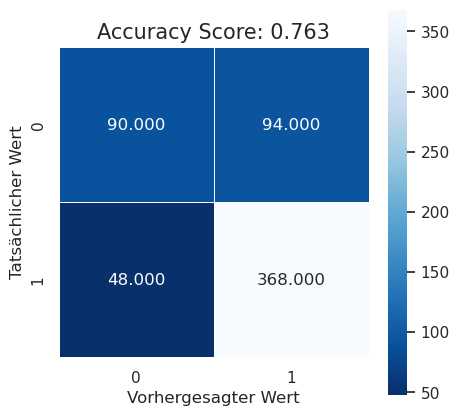

In [23]:
# Accuracy Score
accuracy_lr = accuracy_score(y_test, y_pred_lr)
# Confusion Matrix 
cm = skmetrics.confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Tatsächlicher Wert');
plt.xlabel('Vorhergesagter Wert');
all_sample_title = 'Accuracy Score: {0}'.format(round(accuracy_lr,3))
plt.title(all_sample_title, size = 15);

In [24]:
# Metrics
print('Accuracy Score: {0}'.format(round(accuracy_lr,3)))
precision_lr = precision_score(y_test, y_pred_lr)
print('Precision Score: {0}'.format(round(precision_lr,3)))
recall_lr = recall_score(y_test, y_pred_lr)
print('Recall Score: {0}'.format(round(recall_lr,3)))
auc_lr = roc_auc_score(y_test,y_pred_prob_lr[:,1])
print('Computed AUC: {0}'.format(round(auc_lr,3)))
tpr_lr = recall_lr
tnr_lr = recall_score(y_test, y_pred_lr, pos_label=0)
fpr_lr = 1 - tnr_lr
fnr_lr = 1 - tpr_lr
print('False Positive Rate: {0}'.format(round(fpr_lr,3)))
print('False Negative Rate: {0}'.format(round(fnr_lr,3)))

Accuracy Score: 0.763
Precision Score: 0.797
Recall Score: 0.885
Computed AUC: 0.798
False Positive Rate: 0.511
False Negative Rate: 0.115


In [25]:
# Metrics per GENDER
df_test_lr = pd.DataFrame(X_test)
df_test_lr['COUNTOP1'] = y_test
df_test_lr['y_pred_lr'] = y_pred_lr

tpr_m_lr = recall_score(df_test_lr[df_test_lr['GENDER']==0]['COUNTOP1'],\
                        df_test_lr[df_test_lr['GENDER']==0]['y_pred_lr'])
tnr_m_lr = recall_score(df_test_lr[df_test_lr['GENDER']==0]['COUNTOP1'],\
                        df_test_lr[df_test_lr['GENDER']==0]['y_pred_lr'],pos_label=0)
fpr_m_lr = 1 - tnr_m_lr
fnr_m_lr = 1 - tpr_m_lr
print('False Positive Rate for Males: {0}'.format(round(fpr_m_lr,3)))
print('False Negative Rate for Males: {0}'.format(round(fnr_m_lr,3)))

tpr_f_lr = recall_score(df_test_lr[df_test_lr['GENDER']==1]['COUNTOP1'],\
                        df_test_lr[df_test_lr['GENDER']==1]['y_pred_lr'])
tnr_f_lr = recall_score(df_test_lr[df_test_lr['GENDER']==1]['COUNTOP1'],\
                        df_test_lr[df_test_lr['GENDER']==1]['y_pred_lr'],pos_label=0)
fpr_f_lr = 1 - tnr_f_lr
fnr_f_lr = 1 - tpr_f_lr
print('False Positive Rate for Females: {0}'.format(round(fpr_f_lr,3)))
print('False Negative Rate for Females: {0}'.format(round(fnr_f_lr,3)))

False Positive Rate for Males: 0.336
False Negative Rate for Males: 0.182
False Positive Rate for Females: 0.77
False Negative Rate for Females: 0.076


In [26]:
# Estimated Coefficients
coef_table = pd.DataFrame(list(X_train.columns)).copy()
coef_table.insert(len(coef_table.columns),"Coefs",model_lr.coef_.transpose())
print(coef_table)

              0     Coefs
0           AGE  0.008635
1      ANYLIMIT  0.899002
2       COLLEGE  0.100609
3       HIGHSCH -0.028132
4        GENDER  0.892533
5       MNHPOOR  0.160492
6        insure  0.423802
7           USC  1.188173
8      UNEMPLOY  0.184267
9   MANAGEDCARE  0.600123
10      famsize -0.142546
11        RACE1 -0.050706
12      REGION1  0.074807
13        EDUC1  0.173085
14    MARISTAT1  0.078675
15      INCOME1  0.052640
16      PHSTAT1  0.298849


#### 3.3.3 Random Forest with GENDER

Our third model employs a random forest classifier with default settings.

In [27]:
# Modelling
model_rf = RandomForestClassifier(random_state = 42)
model_rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [28]:
# Prediction
y_pred_rf = model_rf.predict(X_test)
y_pred_prob_rf = model_rf.predict_proba(X_test)

In [29]:
# Target Distribution in the Training and Testing Set per GENDER
# Concatenate the test data with the predictions
df_test_rf = pd.DataFrame(X_test)
df_test_rf['COUNTOP1'] = y_pred_rf
Target_Dist_Test_M_rf = df_test_rf[df_test_rf['GENDER'] == 0]['COUNTOP1'].value_counts(normalize=True).to_frame()
Target_Dist_Test_F_rf = df_test_rf[df_test_rf['GENDER'] == 1]['COUNTOP1'].value_counts(normalize=True).to_frame()

print("Distribution COUNTOP1 testing set for Male: ")
print(Target_Dist_Test_M_rf)
print("Distribution COUNTOP1 testing set for Female: ")
print(Target_Dist_Test_F_rf)

Distribution COUNTOP1 testing set for Male: 
          proportion
COUNTOP1            
1              0.625
0              0.375
Distribution COUNTOP1 testing set for Female: 
          proportion
COUNTOP1            
1           0.892857
0           0.107143


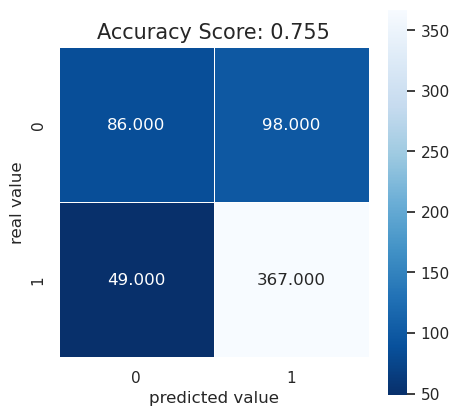

In [30]:
# Accuracy Score
accuracy_rf = accuracy_score(y_test, y_pred_rf)
# Confusion Matrix 
cm = skmetrics.confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('real value');
plt.xlabel('predicted value');
all_sample_title = 'Accuracy Score: {0}'.format(round(accuracy_rf,3))
plt.title(all_sample_title, size = 15);

In [31]:
# Metrics
print('Accuracy Score: {0}'.format(round(accuracy_rf,3)))
precision_rf = precision_score(y_test, y_pred_rf)
print('Precision Score: {0}'.format(round(precision_rf,3)))
recall_rf = recall_score(y_test, y_pred_rf)
print('Recall Score: {0}'.format(round(recall_rf,3)))
auc_rf = roc_auc_score(y_test,y_pred_prob_rf[:,1])
print('Computed AUC: {0}'.format(round(auc_rf,3)))
tpr_rf = recall_rf
tnr_rf = recall_score(y_test, y_pred_rf, pos_label=0)
fpr_rf = 1 - tnr_rf
fnr_rf = 1 - tpr_rf
print('False Positive Rate: {0}'.format(round(fpr_rf,3)))
print('False Negative Rate: {0}'.format(round(fnr_rf,3)))

Accuracy Score: 0.755
Precision Score: 0.789
Recall Score: 0.882
Computed AUC: 0.76
False Positive Rate: 0.533
False Negative Rate: 0.118


In [32]:
# Metrics per GENDER
df_test_rf = pd.DataFrame(X_test)
df_test_rf['COUNTOP1'] = y_test
df_test_rf['y_pred_rf'] = y_pred_rf

tpr_m_rf = recall_score(df_test_rf[df_test_rf['GENDER']==0]['COUNTOP1'],\
                        df_test_rf[df_test_rf['GENDER']==0]['y_pred_rf'])
tnr_m_rf = recall_score(df_test_rf[df_test_rf['GENDER']==0]['COUNTOP1'],\
                        df_test_rf[df_test_rf['GENDER']==0]['y_pred_rf'],pos_label=0)
fpr_m_rf = 1 - tnr_m_rf
fnr_m_rf = 1 - tpr_m_rf
print('False Positive Rate for Males: {0}'.format(round(fpr_m_rf,3)))
print('False Negative Rate for Males: {0}'.format(round(fnr_m_rf,3)))

tpr_f_rf = recall_score(df_test_rf[df_test_rf['GENDER']==1]['COUNTOP1'],\
                        df_test_rf[df_test_rf['GENDER']==1]['y_pred_rf'])
tnr_f_rf = recall_score(df_test_rf[df_test_rf['GENDER']==1]['COUNTOP1'],\
                        df_test_rf[df_test_rf['GENDER']==1]['y_pred_rf'],pos_label=0)
fpr_f_rf = 1 - tnr_f_rf
fnr_f_rf = 1 - tpr_f_rf
print('False Positive Rate for Females: {0}'.format(round(fpr_f_rf,3)))
print('False Negative Rate for Females: {0}'.format(round(fnr_f_rf,3)))

False Positive Rate for Males: 0.391
False Negative Rate for Males: 0.208
False Positive Rate for Females: 0.743
False Negative Rate for Females: 0.065


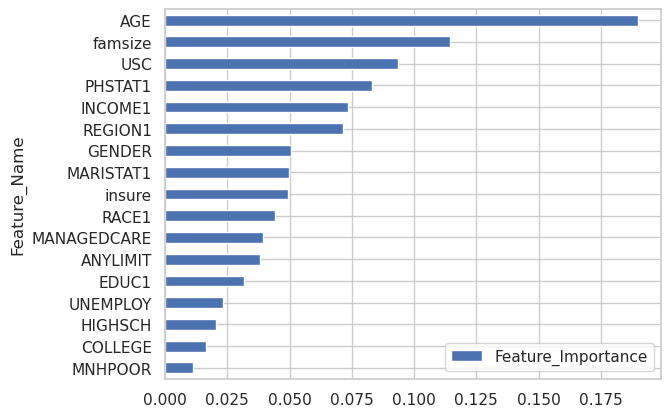

In [33]:
# Feature Importance
Feature_Names_rf = pd.DataFrame(X_train.columns)
Feature_Names_rf.columns = ['Feature_Name']
Feature_Importance_rf = pd.DataFrame(model_rf.feature_importances_)
Feature_Importance_rf.columns = ['Feature_Importance']
RF_FI = Feature_Names_rf.merge(Feature_Importance_rf, left_index=True, right_index=True)
RF_FI.set_index("Feature_Name", inplace = True)
# Ramdom Forest: Feature-Importance plot
RF_FI.sort_values('Feature_Importance')
RF_FI.sort_values('Feature_Importance').plot(kind='barh')
plt.show()

Notably, AGE continues to emerge as the most influential feature, followed by family size (famsize) and USC. Consistent with our previous findings using XGBoost, Random Forest also incorporates the features GENDER and RACE1. 

#### 3.3.4 Comparison of metrics for models with GENDER

A comparative analysis of the accuracy, precision, recall and AUC metrics for all models reveals that logistic regression surpasses machine learning methods employing default parameters in this particular instance.

In [34]:
# Score Table with GENDER
df_Scoretable = pd.DataFrame()
df_Scoretable['Model'] = ['XGBoost', 'Logistic Regression', 'Random Forest']
df_Scoretable['Accuracy Score'] = [accuracy_xgb, accuracy_lr, accuracy_rf]
df_Scoretable['Precision Score'] = [precision_xgb, precision_lr, precision_rf]
df_Scoretable['Recall Score'] = [recall_xgb, recall_lr, recall_rf]
df_Scoretable['Computed AUC'] = [auc_xgb, auc_lr, auc_rf]
df_Scoretable['False Positive Rate'] = [fpr_xgb, fpr_lr, fpr_rf]
df_Scoretable['False Negative Rate'] = [fnr_xgb, fnr_lr, fnr_rf]
df_Scoretable.set_index("Model", inplace = True)
df_Scoretable

,Accuracy Score,Precision Score,Recall Score,Computed AUC,False Positive Rate,False Negative Rate
Model,,,,,,
XGBoost,0.726667,0.791667,0.822115,0.735917,0.489130,0.177885
Logistic Regression,0.763333,0.796537,0.884615,0.797881,0.510870,0.115385
Random Forest,0.755000,0.789247,0.882212,0.759628,0.532609,0.117788


### 3.4 Modelling of COUNTOP1 without GENDER

As our next step, we investigate the relationship between the target variable COUNTOP1 and all features, excluding the sensitive characteristic GENDER.

In [35]:
# X_train_ng without GENDER
X_train_ng = X_train.drop(['GENDER'],axis=1)
X_test_ng = X_test.drop(['GENDER'],axis=1)

#### 3.4.1 XGBoost without GENDER

In [36]:
# Modelling
model_xgb_ng = xgb.XGBClassifier(random_state = 42)
model_xgb_ng.fit(X_train_ng, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [37]:
# Prediction
y_pred_xgb_ng = model_xgb_ng.predict(X_test_ng)
y_pred_prob_xgb_ng = model_xgb_ng.predict_proba(X_test_ng)

In [38]:
# Target Distribution in the Training and Testing Set per GENDER
# Concatenate the test data with the predictions
df_test_xgb_ng = pd.DataFrame(X_test)
df_test_xgb_ng['COUNTOP1'] = y_pred_xgb_ng
Target_Dist_Test_M_xgb_ng = df_test_xgb_ng[df_test_xgb_ng['GENDER'] == 0]['COUNTOP1'].value_counts(normalize=True).to_frame()
Target_Dist_Test_F_xgb_ng = df_test_xgb_ng[df_test_xgb_ng['GENDER'] == 1]['COUNTOP1'].value_counts(normalize=True).to_frame()

print("Distribution COUNTOP1 testing set for Male: ")
print(Target_Dist_Test_M_xgb_ng)
print("Distribution COUNTOP1 testing set for Female: ")
print(Target_Dist_Test_F_xgb_ng)

Distribution COUNTOP1 testing set for Male: 
          proportion
COUNTOP1            
1           0.674242
0           0.325758
Distribution COUNTOP1 testing set for Female: 
          proportion
COUNTOP1            
1           0.758929
0           0.241071


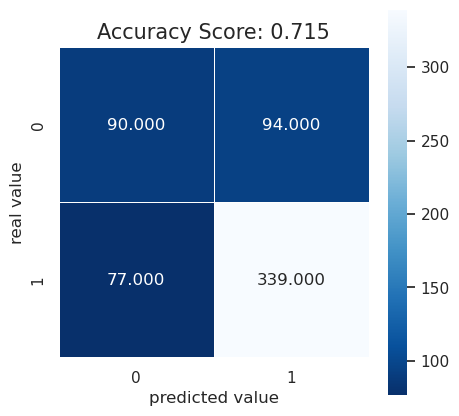

In [39]:
# Accuracy Score
accuracy_xgb_ng = accuracy_score(y_test, y_pred_xgb_ng)
# Confusion Matrix 
cm = skmetrics.confusion_matrix(y_test, y_pred_xgb_ng)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('real value');
plt.xlabel('predicted value');
all_sample_title = 'Accuracy Score: {0}'.format(round(accuracy_xgb_ng,3))
plt.title(all_sample_title, size = 15);

In [40]:
# Metrics
print('Accuracy Score: {0}'.format(round(accuracy_xgb_ng,3)))
precision_xgb_ng = precision_score(y_test, y_pred_xgb_ng)
print('Precision Score: {0}'.format(round(precision_xgb_ng,3)))
recall_xgb_ng = recall_score(y_test, y_pred_xgb_ng)
print('Recall Score: {0}'.format(round(recall_xgb_ng,3)))
auc_xgb_ng = roc_auc_score(y_test,y_pred_prob_xgb_ng[:,1])
print('Computed AUC: {0}'.format(round(auc_xgb_ng,3)))
tpr_xgb_ng = recall_xgb_ng
tnr_xgb_ng = recall_score(y_test, y_pred_xgb_ng, pos_label=0)
fpr_xgb_ng = 1 - tnr_xgb_ng
fnr_xgb_ng = 1 - tpr_xgb_ng
print('False Positive Rate: {0}'.format(round(fpr_xgb_ng,3)))
print('False Negative Rate: {0}'.format(round(fnr_xgb_ng,3)))

Accuracy Score: 0.715
Precision Score: 0.783
Recall Score: 0.815
Computed AUC: 0.726
False Positive Rate: 0.511
False Negative Rate: 0.185


In [41]:
# Metrics per GENDER
df_test_xgb_ng = pd.DataFrame(X_test)
df_test_xgb_ng['COUNTOP1'] = y_test
df_test_xgb_ng['y_pred_xgb_ng'] = y_pred_xgb_ng

tpr_m_xgb_ng = recall_score(df_test_xgb_ng[df_test_xgb_ng['GENDER']==0]['COUNTOP1'],\
                            df_test_xgb_ng[df_test_xgb_ng['GENDER']==0]['y_pred_xgb_ng'])
tnr_m_xgb_ng = recall_score(df_test_xgb_ng[df_test_xgb_ng['GENDER']==0]['COUNTOP1'],\
                            df_test_xgb_ng[df_test_xgb_ng['GENDER']==0]['y_pred_xgb_ng'],pos_label=0)
fpr_m_xgb_ng = 1 - tnr_m_xgb_ng
fnr_m_xgb_ng = 1 - tpr_m_xgb_ng
print('False Positive Rate for Males: {0}'.format(round(fpr_m_xgb_ng,3)))
print('False Negative Rate for Males: {0}'.format(round(fnr_m_xgb_ng,3)))

tpr_f_xgb_ng = recall_score(df_test_xgb_ng[df_test_xgb_ng['GENDER']==1]['COUNTOP1'],\
                            df_test_xgb_ng[df_test_xgb_ng['GENDER']==1]['y_pred_xgb_ng'])
tnr_f_xgb_ng = recall_score(df_test_xgb_ng[df_test_xgb_ng['GENDER']==1]['COUNTOP1'],\
                            df_test_xgb_ng[df_test_xgb_ng['GENDER']==1]['y_pred_xgb_ng'],pos_label=0)
fpr_f_xgb_ng = 1 - tnr_f_xgb_ng
fnr_f_xgb_ng = 1 - tpr_f_xgb_ng
print('False Positive Rate for Females: {0}'.format(round(fpr_f_xgb_ng,3)))
print('False Negative Rate for Females: {0}'.format(round(fnr_f_xgb_ng,3)))

False Positive Rate for Males: 0.445
False Negative Rate for Males: 0.162
False Positive Rate for Females: 0.608
False Negative Rate for Females: 0.198


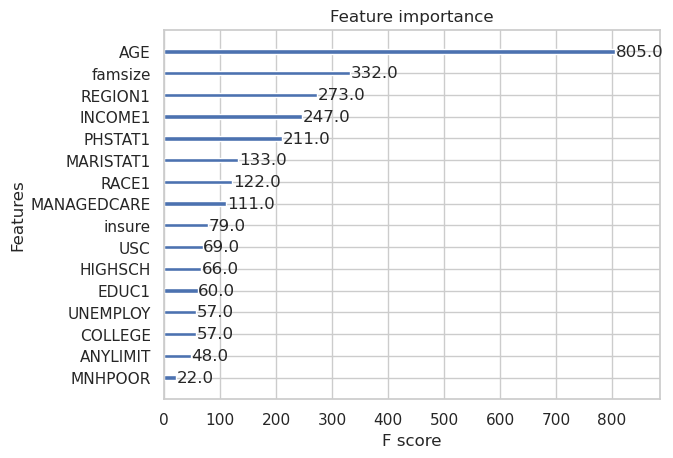

In [42]:
# Feature Importance
plot_importance(model_xgb_ng)
plt.show()

The feature importance ranking obtained without considering GENDER exhibits a comparable profile to that derived when including the sensitive characteristic, suggesting a degree of robustness in the results.

#### 3.4.2 Logistic Regression without GENDER

Next, we employ a Logistic Regression model without GENDER.

In [43]:
# Modelling
model_lr_ng = LogisticRegression(random_state=42)
model_lr_ng.fit(X_train_ng, y_train)

LogisticRegression(random_state=42)

In [44]:
# Prediction
y_pred_lr_ng = model_lr_ng.predict(X_test_ng)
y_pred_prob_lr_ng = model_lr_ng.predict_proba(X_test_ng)

In [45]:
# Target Distribution in the Training and Testing Set per GENDER
# Concatenate the test data with the predictions
df_test_lr_ng = pd.DataFrame(X_test)
df_test_lr_ng['COUNTOP1'] = y_pred_lr_ng
Target_Dist_Test_M_lr_ng = df_test_lr_ng[df_test_lr_ng['GENDER'] == 0]['COUNTOP1'].value_counts(normalize=True).to_frame()
Target_Dist_Test_F_lr_ng = df_test_lr_ng[df_test_lr_ng['GENDER'] == 1]['COUNTOP1'].value_counts(normalize=True).to_frame()

print("Distribution COUNTOP1 testing set for Male: ")
print(Target_Dist_Test_M_lr_ng)
print("Distribution COUNTOP1 testing set for Female: ")
print(Target_Dist_Test_F_lr_ng)

Distribution COUNTOP1 testing set for Male: 
          proportion
COUNTOP1            
1           0.719697
0           0.280303
Distribution COUNTOP1 testing set for Female: 
          proportion
COUNTOP1            
1           0.830357
0           0.169643


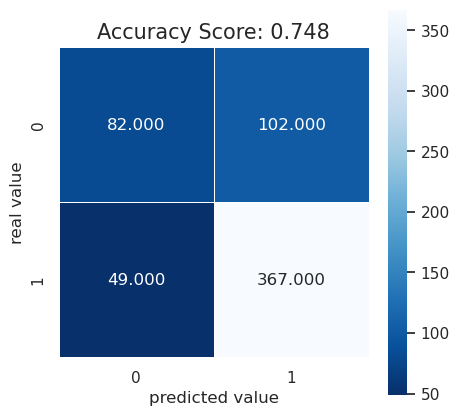

In [46]:
# Accuracy Score
accuracy_lr_ng = accuracy_score(y_test, y_pred_lr_ng)
# Confusion Matrix 
cm = skmetrics.confusion_matrix(y_test, y_pred_lr_ng)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('real value');
plt.xlabel('predicted value');
all_sample_title = 'Accuracy Score: {0}'.format(round(accuracy_lr_ng,3))
plt.title(all_sample_title, size = 15);

In [47]:
# Metrics
print('Accuracy Score: {0}'.format(round(accuracy_lr_ng,3)))
precision_lr_ng = precision_score(y_test, y_pred_lr_ng)
print('Precision Score: {0}'.format(round(precision_lr_ng,3)))
recall_lr_ng = recall_score(y_test, y_pred_lr_ng)
print('Recall Score: {0}'.format(round(recall_lr_ng,3)))
auc_lr_ng = roc_auc_score(y_test,y_pred_prob_lr_ng[:,1])
print('Computed AUC: {0}'.format(round(auc_lr_ng,3)))
tpr_lr_ng = recall_lr_ng
tnr_lr_ng = recall_score(y_test, y_pred_lr_ng, pos_label=0)
fpr_lr_ng = 1 - tnr_lr_ng
fnr_lr_ng = 1 - tpr_lr_ng
print('False Positive Rate: {0}'.format(round(fpr_lr_ng,3)))
print('False Negative Rate: {0}'.format(round(fnr_lr_ng,3)))

Accuracy Score: 0.748
Precision Score: 0.783
Recall Score: 0.882
Computed AUC: 0.791
False Positive Rate: 0.554
False Negative Rate: 0.118


In [48]:
# Metrics per GENDER
df_test_lr_ng = pd.DataFrame(X_test)
df_test_lr_ng['COUNTOP1'] = y_test
df_test_lr_ng['y_pred_lr_ng'] = y_pred_lr_ng

tpr_m_lr_ng = recall_score(df_test_lr_ng[df_test_lr_ng['GENDER']==0]['COUNTOP1'],\
                           df_test_lr_ng[df_test_lr_ng['GENDER']==0]['y_pred_lr_ng'])
tnr_m_lr_ng = recall_score(df_test_lr_ng[df_test_lr_ng['GENDER']==0]['COUNTOP1'],\
                           df_test_lr_ng[df_test_lr_ng['GENDER']==0]['y_pred_lr_ng'],pos_label=0)
fpr_m_lr_ng = 1 - tnr_m_lr_ng
fnr_m_lr_ng = 1 - tpr_m_lr_ng
print('False Positive Rate for Males: {0}'.format(round(fpr_m_lr_ng,3)))
print('False Negative Rate for Males: {0}'.format(round(fnr_m_lr_ng,3)))

tpr_f_lr_ng = recall_score(df_test_lr_ng[df_test_lr_ng['GENDER']==1]['COUNTOP1'],\
                           df_test_lr_ng[df_test_lr_ng['GENDER']==1]['y_pred_lr_ng'])
tnr_f_lr_ng = recall_score(df_test_lr_ng[df_test_lr_ng['GENDER']==1]['COUNTOP1'],\
                           df_test_lr_ng[df_test_lr_ng['GENDER']==1]['y_pred_lr_ng'],pos_label=0)
fpr_f_lr_ng = 1 - tnr_f_lr_ng
fnr_f_lr_ng = 1 - tpr_f_lr_ng
print('False Positive Rate for Females: {0}'.format(round(fpr_f_lr_ng,3)))
print('False Negative Rate for Females: {0}'.format(round(fnr_f_lr_ng,3)))

False Positive Rate for Males: 0.482
False Negative Rate for Males: 0.11
False Positive Rate for Females: 0.662
False Negative Rate for Females: 0.122


In [49]:
# Estimated Coefficients
coef_table_ng = pd.DataFrame(list(X_train_ng.columns)).copy()
coef_table_ng.insert(len(coef_table_ng.columns),"Coefs",model_lr_ng.coef_.transpose())
print(coef_table_ng)

              0     Coefs
0           AGE  0.005368
1      ANYLIMIT  0.818146
2       COLLEGE  0.092997
3       HIGHSCH  0.005386
4       MNHPOOR  0.095511
5        insure  0.415858
6           USC  1.282571
7      UNEMPLOY  0.452984
8   MANAGEDCARE  0.622540
9       famsize -0.123530
10        RACE1 -0.049919
11      REGION1  0.108267
12        EDUC1  0.191379
13    MARISTAT1  0.148092
14      INCOME1  0.027327
15      PHSTAT1  0.309382


#### 3.4.3 Random Forest without GENDER

Our third model employs a random forest classifier with default settings without the sensitive variable GENDER.

In [50]:
# Modelling
model_rf_ng = RandomForestClassifier(random_state = 42)
model_rf_ng.fit(X_train_ng, y_train)

RandomForestClassifier(random_state=42)

In [51]:
# Prediction
y_pred_rf_ng = model_rf_ng.predict(X_test_ng)
y_pred_prob_rf_ng = model_rf_ng.predict_proba(X_test_ng)

In [52]:
# Target Distribution in the Training and Testing Set per GENDER
# Concatenate the test data with the predictions
df_test_rf_ng = pd.DataFrame(X_test)
df_test_rf_ng['COUNTOP1'] = y_pred_rf_ng
Target_Dist_Test_M_rf_ng = df_test_rf_ng[df_test_rf_ng['GENDER'] == 0]['COUNTOP1'].value_counts(normalize=True).to_frame()
Target_Dist_Test_F_rf_ng = df_test_rf_ng[df_test_rf_ng['GENDER'] == 1]['COUNTOP1'].value_counts(normalize=True).to_frame()

print("Distribution COUNTOP1 testing set for Male: ")
print(Target_Dist_Test_M_rf_ng)
print("Distribution COUNTOP1 testing set for Female: ")
print(Target_Dist_Test_F_rf_ng)

Distribution COUNTOP1 testing set for Male: 
          proportion
COUNTOP1            
1           0.700758
0           0.299242
Distribution COUNTOP1 testing set for Female: 
          proportion
COUNTOP1            
1           0.791667
0           0.208333


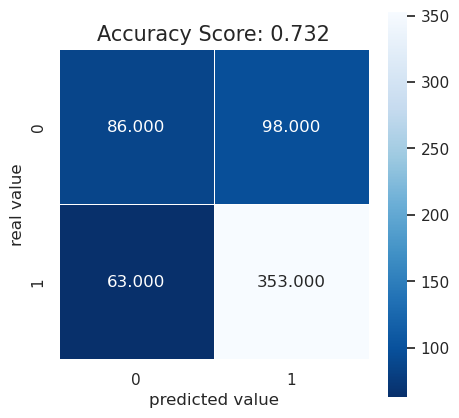

In [53]:
# Accuracy Score
accuracy_rf_ng = accuracy_score(y_test, y_pred_rf_ng)
# Confusion Matrix 
cm = skmetrics.confusion_matrix(y_test, y_pred_rf_ng)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('real value');
plt.xlabel('predicted value');
all_sample_title = 'Accuracy Score: {0}'.format(round(accuracy_rf_ng,3))
plt.title(all_sample_title, size = 15);

In [54]:
# Metrics
print('Accuracy Score: {0}'.format(round(accuracy_rf_ng,3)))
precision_rf_ng = precision_score(y_test, y_pred_rf_ng)
print('Precision Score: {0}'.format(round(precision_rf_ng,3)))
recall_rf_ng = recall_score(y_test, y_pred_rf_ng)
print('Recall Score: {0}'.format(round(recall_rf_ng,3)))
auc_rf_ng = roc_auc_score(y_test,y_pred_prob_rf_ng[:,1])
print('Computed AUC: {0}'.format(round(auc_rf_ng,3)))
tpr_rf_ng = recall_rf_ng
tnr_rf_ng = recall_score(y_test, y_pred_rf_ng, pos_label=0)
fpr_rf_ng = 1 - tnr_rf_ng
fnr_rf_ng = 1 - tpr_rf_ng
print('False Positive Rate: {0}'.format(round(fpr_rf_ng,3)))
print('False Negative Rate: {0}'.format(round(fnr_rf_ng,3)))

Accuracy Score: 0.732
Precision Score: 0.783
Recall Score: 0.849
Computed AUC: 0.756
False Positive Rate: 0.533
False Negative Rate: 0.151


In [55]:
# Metrics per GENDER
df_test_rf_ng = pd.DataFrame(X_test)
df_test_rf_ng['COUNTOP1'] = y_test
df_test_rf_ng['y_pred_rf_ng'] = y_pred_rf_ng

tpr_m_rf_ng = recall_score(df_test_rf_ng[df_test_rf_ng['GENDER']==0]['COUNTOP1'],\
                           df_test_rf_ng[df_test_rf_ng['GENDER']==0]['y_pred_rf_ng'])
tnr_m_rf_ng = recall_score(df_test_rf_ng[df_test_rf_ng['GENDER']==0]['COUNTOP1'],\
                           df_test_rf_ng[df_test_rf_ng['GENDER']==0]['y_pred_rf_ng'],pos_label=0)
fpr_m_rf_ng = 1 - tnr_m_rf_ng
fnr_m_rf_ng = 1 - tpr_m_rf_ng
print('False Positive Rate for Males: {0}'.format(round(fpr_m_rf_ng,3)))
print('False Negative Rate for Males: {0}'.format(round(fnr_m_rf_ng,3)))

tpr_f_rf_ng = recall_score(df_test_rf_ng[df_test_rf_ng['GENDER']==1]['COUNTOP1'],\
                           df_test_rf_ng[df_test_rf_ng['GENDER']==1]['y_pred_rf_ng'])
tnr_f_rf_ng = recall_score(df_test_rf_ng[df_test_rf_ng['GENDER']==1]['COUNTOP1'],\
                           df_test_rf_ng[df_test_rf_ng['GENDER']==1]['y_pred_rf_ng'],pos_label=0)
fpr_f_rf_ng = 1 - tnr_f_rf_ng
fnr_f_rf_ng = 1 - tpr_f_rf_ng
print('False Positive Rate for Females: {0}'.format(round(fpr_f_rf_ng,3)))
print('False Negative Rate for Females: {0}'.format(round(fnr_f_rf_ng,3)))

False Positive Rate for Males: 0.482
False Negative Rate for Males: 0.143
False Positive Rate for Females: 0.608
False Negative Rate for Females: 0.156


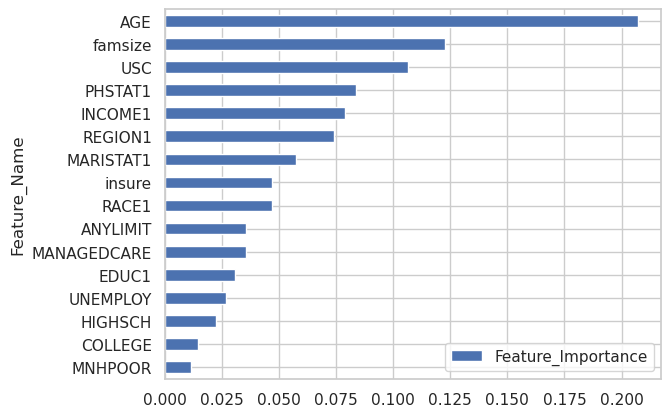

In [56]:
# Feature Importance
Feature_Names_rf_ng = pd.DataFrame(X_train_ng.columns)
Feature_Names_rf_ng.columns = ['Feature_Name']
Feature_Importance_rf_ng = pd.DataFrame(model_rf_ng.feature_importances_)
Feature_Importance_rf_ng.columns = ['Feature_Importance']
RF_FI_ng = Feature_Names_rf_ng.merge(Feature_Importance_rf_ng, left_index=True, right_index=True)
RF_FI_ng.set_index("Feature_Name", inplace = True)
# Ramdom Forest: Feature-Importance plotten
RF_FI_ng.sort_values('Feature_Importance')
RF_FI_ng.sort_values('Feature_Importance').plot(kind='barh')
plt.show()

#### 3.4.4 Comparison of metrics for models without GENDER

A comparative analysis of the accuracy, precision, recall and AUC metrics for all models reveals that logistic regression surpasses machine learning methods employing default parameters in this particular instance.

In [57]:
# Score Table without GENDER
df_Scoretable_ng = pd.DataFrame()
df_Scoretable_ng['Model'] = ['XGB_ng', 'LR_ng', 'RF_ng']
df_Scoretable_ng['Accuracy Score'] = [accuracy_xgb_ng, accuracy_lr_ng, accuracy_rf_ng]
df_Scoretable_ng['Precision Score'] = [precision_xgb_ng, precision_lr_ng, precision_rf_ng]
df_Scoretable_ng['Recall Score'] = [recall_xgb_ng, recall_lr_ng, recall_rf_ng]
df_Scoretable_ng['Computed AUC'] = [auc_xgb_ng, auc_lr_ng, auc_rf_ng]
df_Scoretable_ng['False Positive Rate'] = [fpr_xgb_ng, fpr_lr_ng, fpr_rf_ng]
df_Scoretable_ng['False Negative Rate'] = [fnr_xgb_ng, fnr_lr_ng, fnr_rf_ng]
df_Scoretable_ng.set_index("Model", inplace = True)
df_Scoretable_ng

,Accuracy Score,Precision Score,Recall Score,Computed AUC,False Positive Rate,False Negative Rate
Model,,,,,,
XGB_ng,0.715000,0.782910,0.814904,0.726347,0.510870,0.185096
LR_ng,0.748333,0.782516,0.882212,0.790989,0.554348,0.117788
RF_ng,0.731667,0.782705,0.848558,0.756062,0.532609,0.151442


### 3.5 Preprocessing with Correlation Remover

In our forthcoming discussion, an alternative strategy for feature modeling will be presented. The incorporation of a correlation removal technique enables the mitigation of spurious correlations to the sensitive variable, thereby diminishing the likelihood of proxy variable artefacts.

#### 3.5.1 Correlation Remover

In [58]:
cr = CorrelationRemover(sensitive_feature_ids=['GENDER'], alpha=0.9)
cr.fit(X)

CorrelationRemover(alpha=0.9, sensitive_feature_ids=['GENDER'])

In [59]:
# Transformation of X
X_cr_raw = cr.transform(X)
X_cr_raw

array([[ 2.98103312e+01,  3.76553911e-03, -1.11196617e-02, ...,
         1.08559704e+00,  2.85935264e+00,  8.59633192e-02],
       [ 5.58103312e+01,  1.00376554e+00, -1.11196617e-02, ...,
         1.08559704e+00,  2.85935264e+00,  2.08596332e+00],
       [ 5.48103312e+01,  1.00376554e+00,  9.88880338e-01, ...,
         1.08559704e+00,  3.85935264e+00,  8.59633192e-02],
       ...,
       [ 3.38103312e+01,  1.00376554e+00, -1.11196617e-02, ...,
         8.55970402e-02,  8.59352643e-01,  3.08596332e+00],
       [ 6.48103312e+01,  1.00376554e+00, -1.11196617e-02, ...,
         1.08559704e+00,  1.85935264e+00,  3.08596332e+00],
       [ 2.21702341e+01, -3.37969639e-03,  9.98026565e-03, ...,
        -7.68261860e-02,  3.12623567e+00, -7.71549336e-02]])

In [60]:
# Preparation of X_cr
X_cr = pd.DataFrame(
    X_cr_raw, columns=X.drop(['GENDER'],axis=1).columns
)
X_cr_g = X_cr.copy()
X_cr_g['GENDER'] = X['GENDER']
X_cr_g

,AGE,ANYLIMIT,COLLEGE,HIGHSCH,MNHPOOR,insure,USC,UNEMPLOY,MANAGEDCARE,famsize,RACE1,REGION1,EDUC1,MARISTAT1,INCOME1,PHSTAT1,GENDER
0,29.810331,0.003766,-0.01112,0.012004,0.010919,0.024274,0.066002,0.079220,0.018659,2.973379,3.968656,2.059149,-0.010235,1.085597,2.859353,0.085963,0
1,55.810331,1.003766,-0.01112,1.012004,0.010919,1.024274,1.066002,1.079220,1.018659,2.973379,1.968656,3.059149,0.989765,1.085597,2.859353,2.085963,0
2,54.810331,1.003766,0.98888,0.012004,0.010919,1.024274,1.066002,0.079220,0.018659,1.973379,3.968656,2.059149,1.989765,1.085597,3.859353,0.085963,0
3,47.170234,-0.003380,1.00998,-0.010774,-0.009800,0.978213,0.940761,-0.071103,-0.016747,2.023894,2.028132,0.946912,2.009186,0.923174,4.126236,2.922845,1
4,50.170234,-0.003380,1.00998,-0.010774,-0.009800,0.978213,0.940761,0.928897,0.983253,1.023894,4.028132,-0.053088,2.009186,2.923174,2.126236,1.922845,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,43.810331,1.003766,0.98888,0.012004,0.010919,0.024274,1.066002,0.079220,0.018659,0.973379,2.968656,0.059149,1.989765,0.085597,-0.140647,0.085963,0
1996,23.170234,-0.003380,0.00998,0.989226,-0.009800,-0.021787,-0.059239,-0.071103,-0.016747,7.023894,4.028132,-0.053088,1.009186,-0.076826,3.126236,1.922845,1
1997,33.810331,1.003766,-0.01112,0.012004,1.010919,0.024274,0.066002,0.079220,0.018659,0.973379,3.968656,2.059149,-0.010235,0.085597,0.859353,3.085963,0
1998,64.810331,1.003766,-0.01112,0.012004,0.010919,1.024274,1.066002,1.079220,0.018659,1.973379,3.968656,3.059149,-0.010235,1.085597,1.859353,3.085963,0


In [61]:
# Function to plot heatmap

def plot_heatmap(df, title):
    df_plot = df.copy()
    df_plot["target"] = y
    cols = list(df_plot.columns)

    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(round(df_plot.corr(), 2), cmap="coolwarm")

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(cols)))
    ax.set_xticklabels(cols)
    ax.set_yticks(np.arange(len(cols)))
    ax.set_yticklabels(cols)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=15, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(cols)):
        for j in range(len(cols)):
            ax.text(
                j,
                i,
                round(df_plot.corr().to_numpy()[i, j], 2),
                ha="center",
                va="center",
            )

    ax.set_title(f"{title}")
    plt.show()

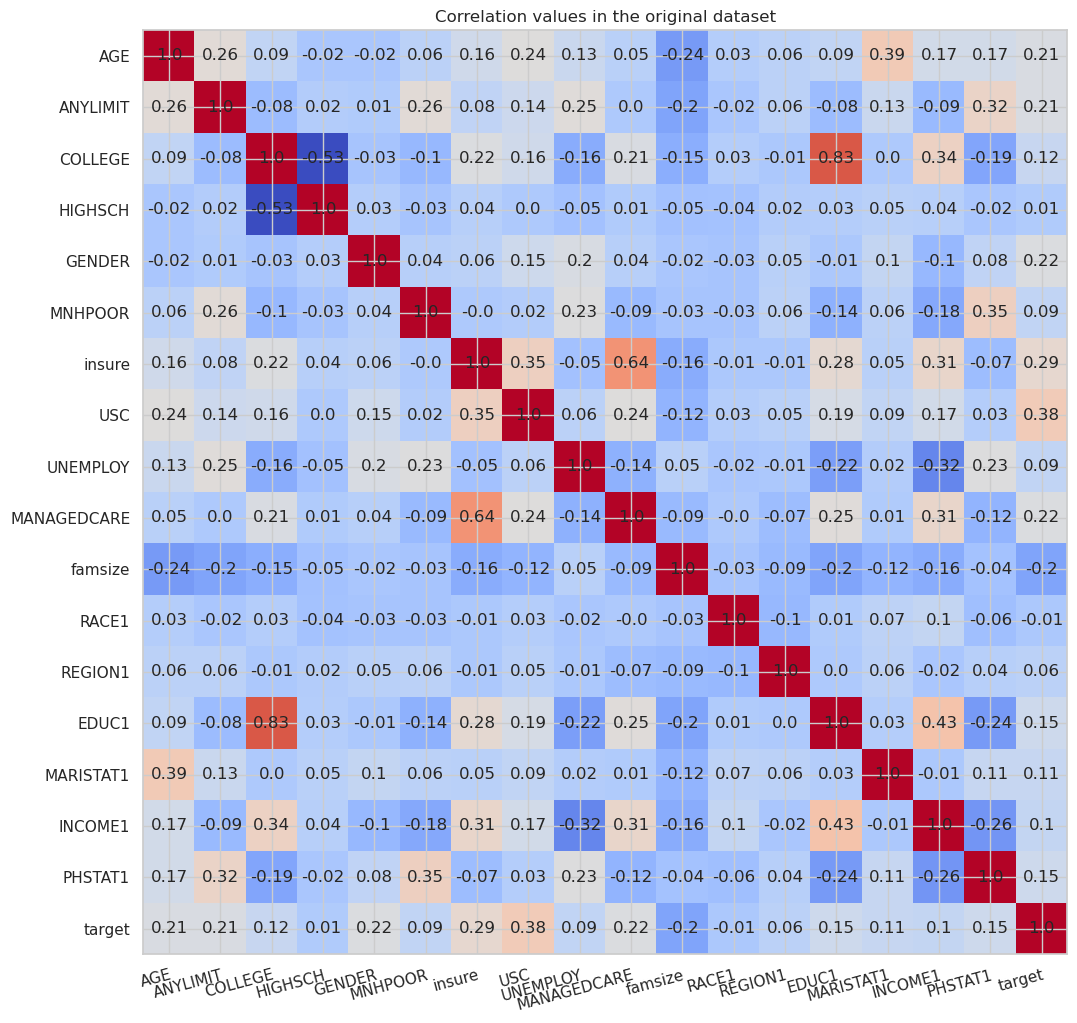

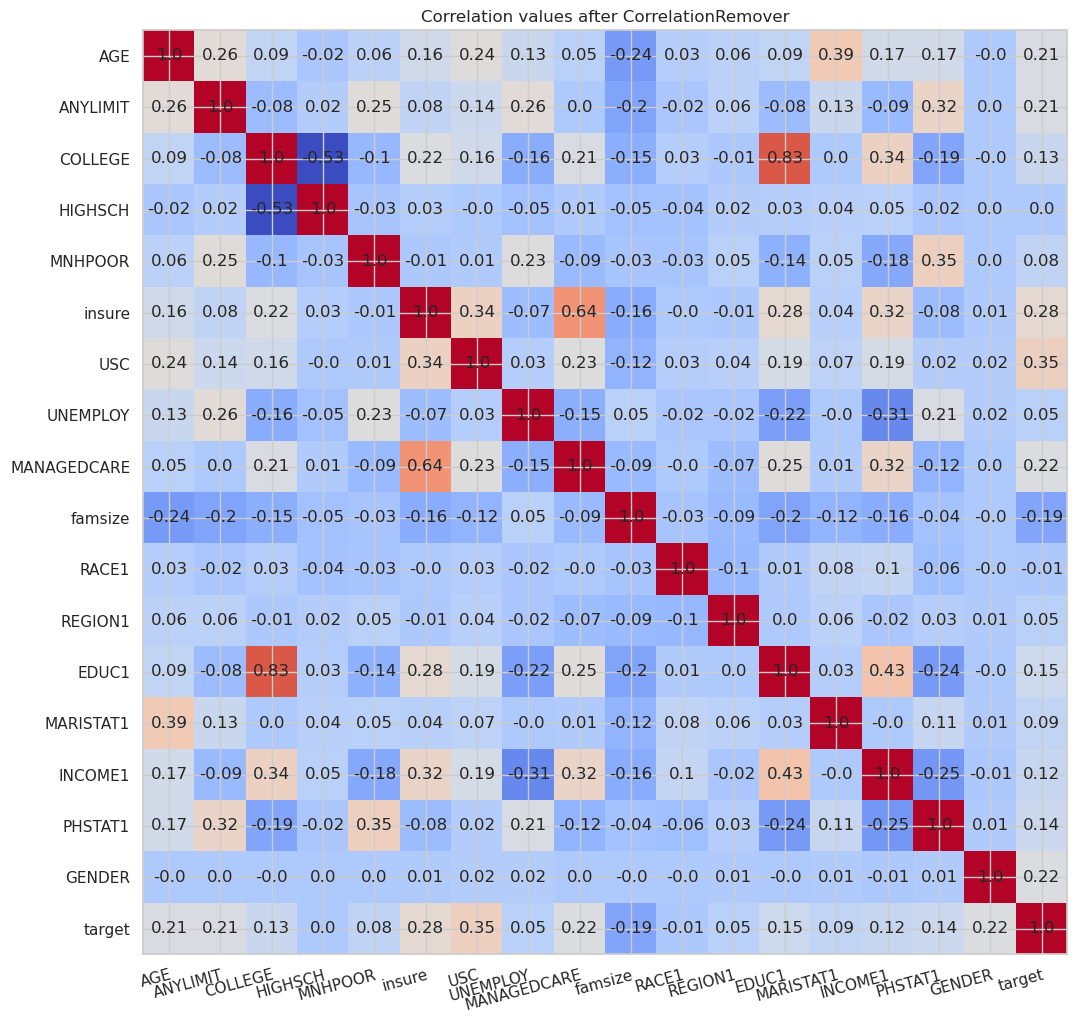

In [62]:
# Plot the correlation values of X and X_cr with correlation removed
plot_heatmap(X, "Correlation values in the original dataset")
plot_heatmap(X_cr_g, "Correlation values after CorrelationRemover")

A significant reduction in the correlation between the variables and the protected feature GENDER has been observed.

#### 3.5.2 Splitting the data into training and testing sets with Correlation Remover

In [63]:
# train and test split
X_train_cr,X_test_cr,y_train_cr,y_test_cr = train_test_split(X_cr,y,test_size=0.3,random_state=42)

# Target Distribution in the Training and Testing Set
Target_Dist_Train_cr = y_train_cr.value_counts(normalize=True).to_frame()
Target_Dist_Test_cr  = y_test_cr.value_counts(normalize=True).to_frame()

print("Verteilung COUNTOP1 Traingsdatensatz: ")
print(Target_Dist_Train_cr)
print("Verteilung COUNTOP1 Testdatensatz: ")
print(Target_Dist_Test_cr)

Verteilung COUNTOP1 Traingsdatensatz: 
          proportion
COUNTOP1            
1           0.668571
0           0.331429
Verteilung COUNTOP1 Testdatensatz: 
          proportion
COUNTOP1            
1           0.693333
0           0.306667


#### 3.5.3 XGBoost with Correlation Remover

In [64]:
# Modelling
model_xgb_cr = xgb.XGBClassifier(random_state = 42)
model_xgb_cr.fit(X_train_cr, y_train_cr)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [65]:
# Prediction
y_pred_xgb_cr = model_xgb_cr.predict(X_test_cr)
y_pred_prob_xgb_cr = model_xgb_cr.predict_proba(X_test_cr)

In [66]:
# Target Distribution in the Training and Testing Set per GENDER
# Concatenate the test data with the predictions
df_test_xgb_cr = pd.DataFrame(X_test)
df_test_xgb_cr['COUNTOP1'] = y_pred_xgb_cr
Target_Dist_Test_M_xgb_cr = df_test_xgb_cr[df_test_xgb_cr['GENDER'] == 0]['COUNTOP1'].value_counts(normalize=True).to_frame()
Target_Dist_Test_F_xgb_cr = df_test_xgb_cr[df_test_xgb_cr['GENDER'] == 1]['COUNTOP1'].value_counts(normalize=True).to_frame()

print("Distribution COUNTOP1 testing set for Male: ")
print(Target_Dist_Test_M_xgb_cr)
print("Distribution COUNTOP1 testing set for Female: ")
print(Target_Dist_Test_F_xgb_cr)

Distribution COUNTOP1 testing set for Male: 
          proportion
COUNTOP1            
1           0.575758
0           0.424242
Distribution COUNTOP1 testing set for Female: 
          proportion
COUNTOP1            
1           0.806548
0           0.193452


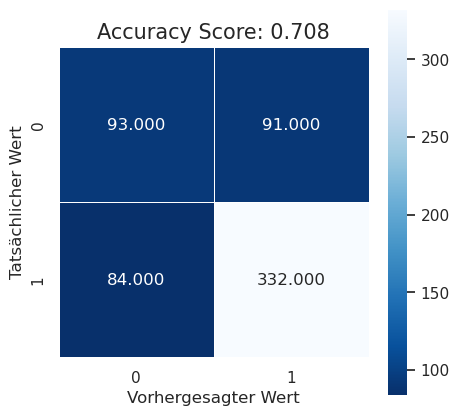

In [67]:
# Accuracy Score
accuracy_xgb_cr = accuracy_score(y_test_cr, y_pred_xgb_cr)
# Confusion Matrix 
cm = skmetrics.confusion_matrix(y_test_cr, y_pred_xgb_cr)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Tatsächlicher Wert');
plt.xlabel('Vorhergesagter Wert');
all_sample_title = 'Accuracy Score: {0}'.format(round(accuracy_xgb_cr,3))
plt.title(all_sample_title, size = 15);

In [68]:
# Metrics
print('Accuracy Score: {0}'.format(round(accuracy_xgb_cr,3)))
precision_xgb_cr = precision_score(y_test_cr, y_pred_xgb_cr)
print('Precision Score: {0}'.format(round(precision_xgb_cr,3)))
recall_xgb_cr = recall_score(y_test_cr, y_pred_xgb_cr)
print('Recall Score: {0}'.format(round(recall_xgb_cr,3)))
auc_xgb_cr = roc_auc_score(y_test_cr,y_pred_prob_xgb_cr[:,1])
print('Computed AUC: {0}'.format(round(auc_xgb_cr,3)))
tpr_xgb_cr = recall_xgb_cr
tnr_xgb_cr = recall_score(y_test, y_pred_xgb_cr, pos_label=0)
fpr_xgb_cr = 1 - tnr_xgb_cr
fnr_xgb_cr = 1 - tpr_xgb_cr
print('False Positive Rate: {0}'.format(round(fpr_xgb_cr,3)))
print('False Negative Rate: {0}'.format(round(fnr_xgb_cr,3)))

Accuracy Score: 0.708
Precision Score: 0.785
Recall Score: 0.798
Computed AUC: 0.74
False Positive Rate: 0.495
False Negative Rate: 0.202


In [69]:
# Metrics per GENDER
df_test_xgb_cr = pd.DataFrame(X_test)
df_test_xgb_cr['COUNTOP1'] = y_test_cr
df_test_xgb_cr['y_pred_xgb_cr'] = y_pred_xgb_cr

tpr_m_xgb_cr = recall_score(df_test_xgb_cr[df_test_xgb_cr['GENDER']==0]['COUNTOP1'],\
                            df_test_xgb_cr[df_test_xgb_cr['GENDER']==0]['y_pred_xgb_cr'])
tnr_m_xgb_cr = recall_score(df_test_xgb_cr[df_test_xgb_cr['GENDER']==0]['COUNTOP1'],\
                            df_test_xgb_cr[df_test_xgb_cr['GENDER']==0]['y_pred_xgb_cr'],pos_label=0)
fpr_m_xgb_cr = 1 - tnr_m_xgb_cr
fnr_m_xgb_cr = 1 - tpr_m_xgb_cr
print('False Positive Rate for Males: {0}'.format(round(fpr_m_xgb_cr,3)))
print('False Negative Rate for Males: {0}'.format(round(fnr_m_xgb_cr,3)))

tpr_f_xgb_cr = recall_score(df_test_xgb_cr[df_test_xgb_cr['GENDER']==1]['COUNTOP1'],\
                            df_test_xgb_cr[df_test_xgb_cr['GENDER']==1]['y_pred_xgb_cr'])
tnr_f_xgb_cr = recall_score(df_test_xgb_cr[df_test_xgb_cr['GENDER']==1]['COUNTOP1'],\
                            df_test_xgb_cr[df_test_xgb_cr['GENDER']==1]['y_pred_xgb_cr'],pos_label=0)
fpr_f_xgb_cr = 1 - tnr_f_xgb_cr
fnr_f_xgb_cr = 1 - tpr_f_xgb_cr
print('False Positive Rate for Females: {0}'.format(round(fpr_f_xgb_cr,3)))
print('False Negative Rate for Females: {0}'.format(round(fnr_f_xgb_cr,3)))

False Positive Rate for Males: 0.373
False Negative Rate for Males: 0.279
False Positive Rate for Females: 0.676
False Negative Rate for Females: 0.156


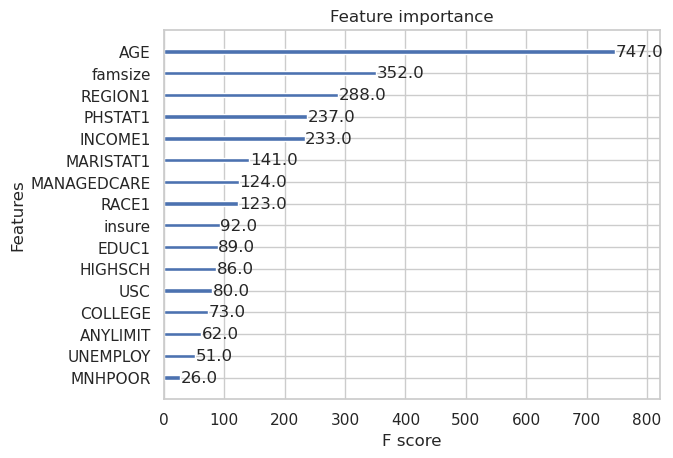

In [70]:
# Feature Importance
plot_importance(model_xgb_cr)
plt.show()

Our results indicate that the XGBoost model equipped with a correlation remover achieves inferior performance on all metrics except recall compared to its counterpart without the GENDER variable. Furthermore, we observe a reversal in the feature importance rankings of INCOME1 and PHSTAT1.

#### 3.5.4 Logistic Regression with Correlation Remover

In [71]:
# Modelling
model_lr_cr = LogisticRegression(random_state=42)
model_lr_cr.fit(X_train_cr, y_train_cr)

LogisticRegression(random_state=42)

In [72]:
# Prediction
y_pred_lr_cr = model_lr_cr.predict(X_test_cr)
y_pred_prob_lr_cr = model_lr_cr.predict_proba(X_test_cr)

In [73]:
# Target Distribution in the Training and Testing Set per GENDER
# Concatenate the test data with the predictions
df_test_lr_cr = pd.DataFrame(X_test)
df_test_lr_cr['COUNTOP1'] = y_pred_lr_cr
Target_Dist_Test_M_lr_cr = df_test_lr_cr[df_test_lr_cr['GENDER'] == 0]['COUNTOP1'].value_counts(normalize=True).to_frame()
Target_Dist_Test_F_lr_cr = df_test_lr_cr[df_test_lr_cr['GENDER'] == 1]['COUNTOP1'].value_counts(normalize=True).to_frame()

print("Distribution COUNTOP1 testing set for Male: ")
print(Target_Dist_Test_M_lr_cr)
print("Distribution COUNTOP1 testing set for Female: ")
print(Target_Dist_Test_F_lr_cr)

Distribution COUNTOP1 testing set for Male: 
          proportion
COUNTOP1            
1               0.75
0               0.25
Distribution COUNTOP1 testing set for Female: 
          proportion
COUNTOP1            
1           0.809524
0           0.190476


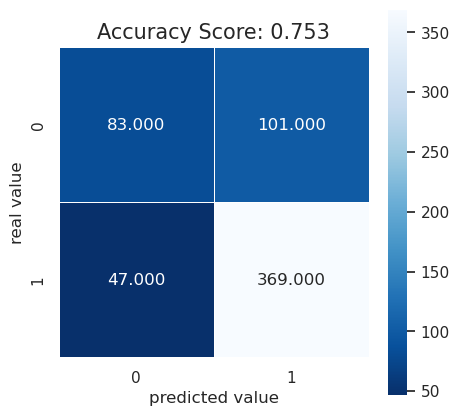

In [74]:
# Accuracy Score
accuracy_lr_cr = accuracy_score(y_test_cr, y_pred_lr_cr)
# Confusion Matrix 
cm = skmetrics.confusion_matrix(y_test_cr, y_pred_lr_cr)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('real value');
plt.xlabel('predicted value');
all_sample_title = 'Accuracy Score: {0}'.format(round(accuracy_lr_cr,3))
plt.title(all_sample_title, size = 15);

In [75]:
# Metrics
print('Accuracy Score: {0}'.format(round(accuracy_lr_cr,3)))
precision_lr_cr = precision_score(y_test_cr, y_pred_lr_cr)
print('Precision Score: {0}'.format(round(precision_lr_cr,3)))
recall_lr_cr = recall_score(y_test_cr, y_pred_lr_cr)
print('Recall Score: {0}'.format(round(recall_lr_cr,3)))
auc_lr_cr = roc_auc_score(y_test_cr,y_pred_prob_lr_cr[:,1])
print('Computed AUC: {0}'.format(round(auc_lr_cr,3)))
tpr_lr_cr = recall_lr_cr
tnr_lr_cr = recall_score(y_test, y_pred_lr_cr, pos_label=0)
fpr_lr_cr = 1 - tnr_lr_cr
fnr_lr_cr = 1 - tpr_lr_cr
print('False Positive Rate: {0}'.format(round(fpr_lr_cr,3)))
print('False Negative Rate: {0}'.format(round(fnr_lr_cr,3)))

Accuracy Score: 0.753
Precision Score: 0.785
Recall Score: 0.887
Computed AUC: 0.779
False Positive Rate: 0.549
False Negative Rate: 0.113


Also in this case the results indicate that the Logistic Regression model equipped with a correlation remover achieves superior performance on all metrics except AUC compared to its counterpart without the GENDER variable.

In [76]:
# Metrics per GENDER
df_test_lr_cr = pd.DataFrame(X_test)
df_test_lr_cr['COUNTOP1'] = y_test_cr
df_test_lr_cr['y_pred_lr_cr'] = y_pred_lr_cr

tpr_m_lr_cr = recall_score(df_test_lr_cr[df_test_lr_cr['GENDER']==0]['COUNTOP1'],\
                           df_test_lr_cr[df_test_lr_cr['GENDER']==0]['y_pred_lr_cr'])
tnr_m_lr_cr = recall_score(df_test_lr_cr[df_test_lr_cr['GENDER']==0]['COUNTOP1'],\
                           df_test_lr_cr[df_test_lr_cr['GENDER']==0]['y_pred_lr_cr'],pos_label=0)
fpr_m_lr_cr = 1 - tnr_m_lr_cr
fnr_m_lr_cr = 1 - tpr_m_lr_cr
print('False Positive Rate for Males: {0}'.format(round(fpr_m_lr_cr,3)))
print('False Negative Rate for Males: {0}'.format(round(fnr_m_lr_cr,3)))

tpr_f_lr_cr = recall_score(df_test_lr_cr[df_test_lr_cr['GENDER']==1]['COUNTOP1'],\
                           df_test_lr_cr[df_test_lr_cr['GENDER']==1]['y_pred_lr_cr'])
tnr_f_lr_cr = recall_score(df_test_lr_cr[df_test_lr_cr['GENDER']==1]['COUNTOP1'],\
                           df_test_lr_cr[df_test_lr_cr['GENDER']==1]['y_pred_lr_cr'],pos_label=0)
fpr_f_lr_cr = 1 - tnr_f_lr_cr
fnr_f_lr_cr = 1 - tpr_f_lr_cr
print('False Positive Rate for Females: {0}'.format(round(fpr_f_lr_cr,3)))
print('False Negative Rate for Females: {0}'.format(round(fnr_f_lr_cr,3)))

False Positive Rate for Males: 0.518
False Negative Rate for Males: 0.084
False Positive Rate for Females: 0.595
False Negative Rate for Females: 0.13


In [77]:
# Estimated Coefficients
coef_table_cr = pd.DataFrame(list(X_train_cr.columns)).copy()
coef_table_cr.insert(len(coef_table_cr.columns),"Coefs",model_lr_cr.coef_.transpose())
print(coef_table_cr)

              0     Coefs
0           AGE  0.008788
1      ANYLIMIT  0.831369
2       COLLEGE  0.090897
3       HIGHSCH -0.021714
4       MNHPOOR  0.079827
5        insure  0.384274
6           USC  1.177314
7      UNEMPLOY  0.248504
8   MANAGEDCARE  0.578991
9       famsize -0.116194
10        RACE1 -0.031073
11      REGION1  0.070958
12        EDUC1  0.160081
13    MARISTAT1  0.078967
14      INCOME1  0.050110
15      PHSTAT1  0.276825


#### 3.5.5 Random Forest with Correlation Remover

In [78]:
# Modelling
model_rf_cr = RandomForestClassifier(random_state = 42)
model_rf_cr.fit(X_train_cr, y_train_cr)

RandomForestClassifier(random_state=42)

In [79]:
# Prediction
y_pred_rf_cr = model_rf_cr.predict(X_test_cr)
y_pred_prob_rf_cr = model_rf_cr.predict_proba(X_test_cr)

In [80]:
# Target Distribution in the Training and Testing Set per GENDER
# Concatenate the test data with the predictions
df_test_rf_cr = pd.DataFrame(X_test)
df_test_rf_cr['COUNTOP1'] = y_pred_rf_cr
Target_Dist_Test_M_rf_cr = df_test_rf_cr[df_test_rf_cr['GENDER'] == 0]['COUNTOP1'].value_counts(normalize=True).to_frame()
Target_Dist_Test_F_rf_cr = df_test_rf_cr[df_test_rf_cr['GENDER'] == 1]['COUNTOP1'].value_counts(normalize=True).to_frame()

print("Distribution COUNTOP1 testing set for Male: ")
print(Target_Dist_Test_M_rf_cr)
print("Distribution COUNTOP1 testing set for Female: ")
print(Target_Dist_Test_F_rf_cr)

Distribution COUNTOP1 testing set for Male: 
          proportion
COUNTOP1            
1           0.613636
0           0.386364
Distribution COUNTOP1 testing set for Female: 
          proportion
COUNTOP1            
1           0.895833
0           0.104167


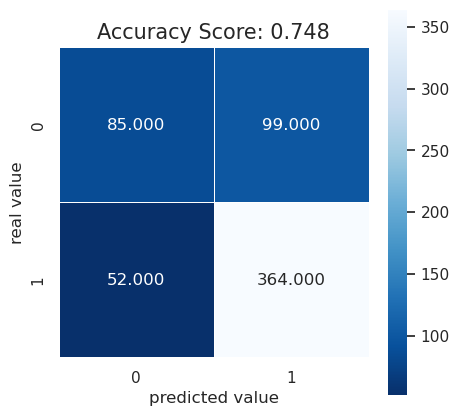

In [81]:
# Accuracy Score
accuracy_rf_cr = accuracy_score(y_test_cr, y_pred_rf_cr)
# Confusion Matrix 
cm = skmetrics.confusion_matrix(y_test_cr, y_pred_rf_cr)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('real value');
plt.xlabel('predicted value');
all_sample_title = 'Accuracy Score: {0}'.format(round(accuracy_rf_cr,3))
plt.title(all_sample_title, size = 15);

In [82]:
# Metrics
print('Accuracy Score: {0}'.format(round(accuracy_rf_cr,3)))
precision_rf_cr = precision_score(y_test_cr, y_pred_rf_cr)
print('Precision Score: {0}'.format(round(precision_rf,3)))
recall_rf_cr = recall_score(y_test_cr, y_pred_rf_cr)
print('Recall Score: {0}'.format(round(recall_rf_cr,3)))
auc_rf_cr = roc_auc_score(y_test_cr,y_pred_prob_rf_cr[:,1])
print('Computed AUC: {0}'.format(round(auc_rf_cr,3)))
tpr_rf_cr = recall_rf_cr
tnr_rf_cr = recall_score(y_test, y_pred_rf_cr, pos_label=0)
fpr_rf_cr = 1 - tnr_rf_cr
fnr_rf_cr = 1 - tpr_rf_cr
print('False Positive Rate: {0}'.format(round(fpr_rf_cr,3)))
print('False Negative Rate: {0}'.format(round(fnr_rf_cr,3)))

Accuracy Score: 0.748
Precision Score: 0.789
Recall Score: 0.875
Computed AUC: 0.754
False Positive Rate: 0.538
False Negative Rate: 0.125


In [83]:
# Metrics per GENDER
df_test_rf_cr = pd.DataFrame(X_test)
df_test_rf_cr['COUNTOP1'] = y_test_cr
df_test_rf_cr['y_pred_rf_cr'] = y_pred_rf_cr

tpr_m_rf_cr = recall_score(df_test_rf_cr[df_test_rf_cr['GENDER']==0]['COUNTOP1'],\
                           df_test_rf_cr[df_test_rf_cr['GENDER']==0]['y_pred_rf_cr'])
tnr_m_rf_cr = recall_score(df_test_rf_cr[df_test_rf_cr['GENDER']==0]['COUNTOP1'],\
                           df_test_rf_cr[df_test_rf_cr['GENDER']==0]['y_pred_rf_cr'],pos_label=0)
fpr_m_rf_cr = 1 - tnr_m_rf_cr
fnr_m_rf_cr = 1 - tpr_m_rf_cr
print('False Positive Rate for Males: {0}'.format(round(fpr_m_rf_cr,3)))
print('False Negative Rate for Males: {0}'.format(round(fnr_m_rf_cr,3)))

tpr_f_rf_cr = recall_score(df_test_rf_cr[df_test_rf_cr['GENDER']==1]['COUNTOP1'],\
                           df_test_rf_cr[df_test_rf_cr['GENDER']==1]['y_pred_rf_cr'])
tnr_f_rf_cr = recall_score(df_test_rf_cr[df_test_rf_cr['GENDER']==1]['COUNTOP1'],\
                           df_test_rf_cr[df_test_rf_cr['GENDER']==1]['y_pred_rf_cr'],pos_label=0)
fpr_f_rf_cr = 1 - tnr_f_rf_cr
fnr_f_rf_cr = 1 - tpr_f_rf_cr
print('False Positive Rate for Females: {0}'.format(round(fpr_f_rf_cr,3)))
print('False Negative Rate for Females: {0}'.format(round(fnr_f_rf_cr,3)))

False Positive Rate for Males: 0.382
False Negative Rate for Males: 0.221
False Positive Rate for Females: 0.77
False Negative Rate for Females: 0.069


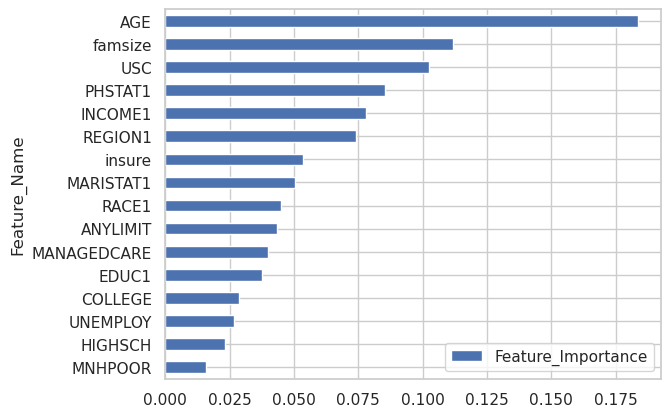

In [84]:
# Feature Importance
Feature_Names_rf_cr = pd.DataFrame(X_train_cr.columns)
Feature_Names_rf_cr.columns = ['Feature_Name']
Feature_Importance_rf_cr = pd.DataFrame(model_rf_cr.feature_importances_)
Feature_Importance_rf_cr.columns = ['Feature_Importance']
RF_FI_cr = Feature_Names_rf_cr.merge(Feature_Importance_rf_cr, left_index=True, right_index=True)
RF_FI_cr.set_index("Feature_Name", inplace = True)
# Ramdom Forest: Feature-Importance plotten
RF_FI_cr.sort_values('Feature_Importance')
RF_FI_cr.sort_values('Feature_Importance').plot(kind='barh')
plt.show()

Also in this case the results indicate that the Random Forest model equipped with a correlation remover achieves superior performance on all metrics except AUC compared to its counterpart without the GENDER variable. Notably, the relative importance of the top-ranked features remained unchanged.

#### 3.5.6 Comparison of metrics for models with Correlation Remover

A comparative analysis of the accuracy, precision, recall and AUC metrics for all models reveals that logistic regression surpasses machine learning methods employing default parameters in this particular instance.

In [85]:
# Score Table with Correlation Remover
df_Scoretable_cr = pd.DataFrame()
df_Scoretable_cr['Model'] = ['XGB_cr', 'LR_cr', 'RF_cr']
df_Scoretable_cr['Accuracy Score'] = [accuracy_xgb_cr, accuracy_lr_cr, accuracy_rf_cr]
df_Scoretable_cr['Precision Score'] = [precision_xgb_cr, precision_lr_cr, precision_rf_cr]
df_Scoretable_cr['Recall Score'] = [recall_xgb_cr, recall_lr_cr, recall_rf_cr]
df_Scoretable_cr['Computed AUC'] = [auc_xgb_cr, auc_lr_cr, auc_rf_cr]
df_Scoretable_cr['False Positive Rate'] = [fpr_xgb_cr, fpr_lr_cr, fpr_rf_cr]
df_Scoretable_cr['False Negative Rate'] = [fnr_xgb_cr, fnr_lr_cr, fnr_rf_cr]
df_Scoretable_cr.set_index("Model", inplace = True)
df_Scoretable_cr

,Accuracy Score,Precision Score,Recall Score,Computed AUC,False Positive Rate,False Negative Rate
Model,,,,,,
XGB_cr,0.708333,0.784870,0.798077,0.740254,0.494565,0.201923
LR_cr,0.753333,0.785106,0.887019,0.779212,0.548913,0.112981
RF_cr,0.748333,0.786177,0.875000,0.753926,0.538043,0.125000


### 3.6 Comparison of Metrics for all models

A comparative analysis of the accuracy, precision, recall and AUC metrics for all models reveals that logistic regression surpasses machine learning methods employing default parameters in this particular instance.

In [86]:
# Score Table for all Models
df_Scoretable_sum = pd.DataFrame()
df_Scoretable_sum['Model'] = ['XGB','XGB_ng','XGB_cr', 'LR','LR_ng','LR_cr', 'RF', 'RF_ng', 'RF_cr']
df_Scoretable_sum['Accuracy Score'] = [accuracy_xgb, accuracy_xgb_ng, accuracy_xgb_cr, \
                                       accuracy_lr, accuracy_lr_ng, accuracy_lr_cr, \
                                       accuracy_rf, accuracy_rf_ng, accuracy_rf_cr]
df_Scoretable_sum['Precision Score'] = [precision_xgb, precision_xgb_ng, precision_xgb_cr, \
                                        precision_lr, precision_lr_ng, precision_lr_cr, \
                                        precision_rf, precision_rf_ng, precision_rf_cr]
df_Scoretable_sum['Recall Score'] = [recall_xgb, recall_xgb_ng, recall_xgb_cr, \
                                     recall_lr, recall_lr_ng, recall_lr_cr, \
                                     recall_rf, recall_rf_ng, recall_rf_cr]
df_Scoretable_sum['Computed AUC'] = [auc_xgb, auc_xgb_ng, auc_xgb_cr, \
                                     auc_lr, auc_lr_ng, auc_lr_cr, \
                                     auc_rf, auc_rf_ng, auc_rf_cr]
df_Scoretable_sum['False Positive Rate'] = [fpr_xgb, fpr_xgb_ng, fpr_xgb_cr, \
                                            fpr_lr, fpr_lr_ng, fpr_lr_cr, \
                                            fpr_rf, fpr_rf_ng, fpr_rf_cr]
df_Scoretable_sum['False Negative Rate'] = [fnr_xgb, fnr_xgb_ng, fnr_xgb_cr, \
                                            fnr_lr, fnr_lr_ng, fnr_lr_cr, \
                                            fnr_rf, fnr_rf_ng, fnr_rf_cr]
df_Scoretable_sum.set_index("Model", inplace = True)
df_Scoretable_sum

,Accuracy Score,Precision Score,Recall Score,Computed AUC,False Positive Rate,False Negative Rate
Model,,,,,,
XGB,0.726667,0.791667,0.822115,0.735917,0.489130,0.177885
XGB_ng,0.715000,0.782910,0.814904,0.726347,0.510870,0.185096
XGB_cr,0.708333,0.784870,0.798077,0.740254,0.494565,0.201923
LR,0.763333,0.796537,0.884615,0.797881,0.510870,0.115385
LR_ng,0.748333,0.782516,0.882212,0.790989,0.554348,0.117788
LR_cr,0.753333,0.785106,0.887019,0.779212,0.548913,0.112981
RF,0.755000,0.789247,0.882212,0.759628,0.532609,0.117788
RF_ng,0.731667,0.782705,0.848558,0.756062,0.532609,0.151442
RF_cr,0.748333,0.786177,0.875000,0.753926,0.538043,0.125000


- A comparative analysis reveals that XGBoost models with a correlation remover exhibit lightly inferior performance compared to their counterparts lacking the gender variable, and both inferior to the model incorporating gender information. 

- Conversely, Logistic Regression and Random Forest models equipped with a correlation remover demonstrate performance metrics comparable to those attained by models including gender information and lightly superior to the model lacking the gender variable.

In [87]:
# False Rate per Gender for all Models
df_falserate_sum = pd.DataFrame()
df_falserate_sum['Model'] = ['XGB','XGB_ng','XGB_cr', 'LR','LR_ng','LR_cr', 'RF', 'RF_ng', 'RF_cr']
df_falserate_sum['False Positive Rate for Males'] = [fpr_m_xgb, fpr_m_xgb_ng, fpr_m_xgb_cr, \
                                                     fpr_m_lr, fpr_m_lr_ng, fpr_m_lr_cr, \
                                                     fpr_m_rf, fpr_m_rf_ng, fpr_m_rf_cr]
df_falserate_sum['False Negative Rate for Males'] = [fnr_m_xgb, fnr_m_xgb_ng, fnr_m_xgb_cr, \
                                                     fnr_m_lr, fnr_m_lr_ng, fnr_m_lr_cr, \
                                                     fnr_m_rf, fnr_m_rf_ng, fnr_m_rf_cr]
df_falserate_sum['False Positive Rate for Females'] = [fpr_f_xgb, fpr_f_xgb_ng, fpr_f_xgb_cr, \
                                                       fpr_f_lr, fpr_f_lr_ng, fpr_f_lr_cr, \
                                                       fpr_f_rf, fpr_f_rf_ng, fpr_f_rf_cr]
df_falserate_sum['False Negative Rate for Females'] = [fnr_f_xgb, fnr_f_xgb_ng, fnr_f_xgb_cr, \
                                                        fnr_f_lr, fnr_f_lr_ng, fnr_f_lr_cr, \
                                                        fnr_f_rf, fnr_f_rf_ng, fnr_f_rf_cr]
df_falserate_sum.set_index("Model", inplace = True)
df_falserate_sum

,False Positive Rate for Males,False Negative Rate for Males,False Positive Rate for Females,False Negative Rate for Females
Model,,,,
XGB,0.327273,0.246753,0.729730,0.137405
XGB_ng,0.445455,0.162338,0.608108,0.198473
XGB_cr,0.372727,0.279221,0.675676,0.156489
LR,0.336364,0.181818,0.770270,0.076336
LR_ng,0.481818,0.110390,0.662162,0.122137
LR_cr,0.518182,0.084416,0.594595,0.129771
RF,0.390909,0.207792,0.743243,0.064885
RF_ng,0.481818,0.142857,0.608108,0.156489
RF_cr,0.381818,0.220779,0.770270,0.068702


- In all models examined, females exhibited a significantly higher false positive rate compared to males. 
- Notably, the incorporation of gender as a variable into the ng-models substantially mitigated this disparity. 
- However, the Correlation Remover only achieved a reduction in disparity for XGBoost and Logistic Regression models, while actually increasing the gap in the Random Forest model. This finding underscores that the Correlation Remover does not guarantee a reduction in bias.

---

## 4. Plotting for Metrics Assessment

For a concise and interpretable comparison of the metrics, the MetricFrame function from the Fairlearn library can be utilized. This tool offers a graphical display of various metrics in relation to the protected variable.

For the purpose of illustration, we generate MetricFrames for each of the three logistic regression models.

In [88]:
# Define Metrics for the MetricFrame
equalErrMetrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    "selection rate": selection_rate,
    "count": count,
}

### 4.1 MetricFrame Visualisation

#### 4.1.1 Logistic Regression with GENDER

In [89]:
## MetricFrame
metric_frame_lr = MetricFrame(
    metrics=equalErrMetrics, y_true=y_test, y_pred=y_pred_lr, sensitive_features=X_test.GENDER
)

array([[<Axes: title={'center': 'accuracy'}, xlabel='GENDER'>,
        <Axes: title={'center': 'precision'}, xlabel='GENDER'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='GENDER'>],
       [<Axes: title={'center': 'false negative rate'}, xlabel='GENDER'>,
        <Axes: title={'center': 'selection rate'}, xlabel='GENDER'>,
        <Axes: title={'center': 'count'}, xlabel='GENDER'>],
       [<Axes: xlabel='GENDER'>, <Axes: xlabel='GENDER'>,
        <Axes: xlabel='GENDER'>]], dtype=object)

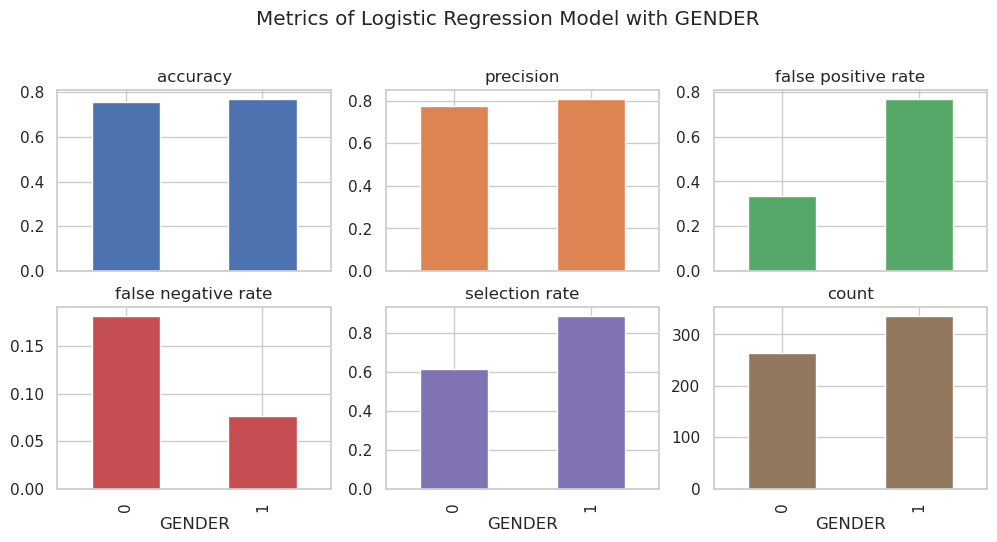

In [90]:
# Generate MetricFrame
metric_frame_lr.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Metrics of Logistic Regression Model with GENDER",
)

A closer examination of the MetricFrames reveals that in the reference model men exhibit significantly higher false negative rates compared to women, whereas women display substantially higher false positive rates and selection rates.

#### 4.1.2 Logistic Regression without GENDER

In [91]:
## MetricFrame
metric_frame_lr_ng = MetricFrame(
    metrics=equalErrMetrics, y_true=y_test, y_pred=y_pred_lr_ng, sensitive_features=X_test.GENDER
)

array([[<Axes: title={'center': 'accuracy'}, xlabel='GENDER'>,
        <Axes: title={'center': 'precision'}, xlabel='GENDER'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='GENDER'>],
       [<Axes: title={'center': 'false negative rate'}, xlabel='GENDER'>,
        <Axes: title={'center': 'selection rate'}, xlabel='GENDER'>,
        <Axes: title={'center': 'count'}, xlabel='GENDER'>],
       [<Axes: xlabel='GENDER'>, <Axes: xlabel='GENDER'>,
        <Axes: xlabel='GENDER'>]], dtype=object)

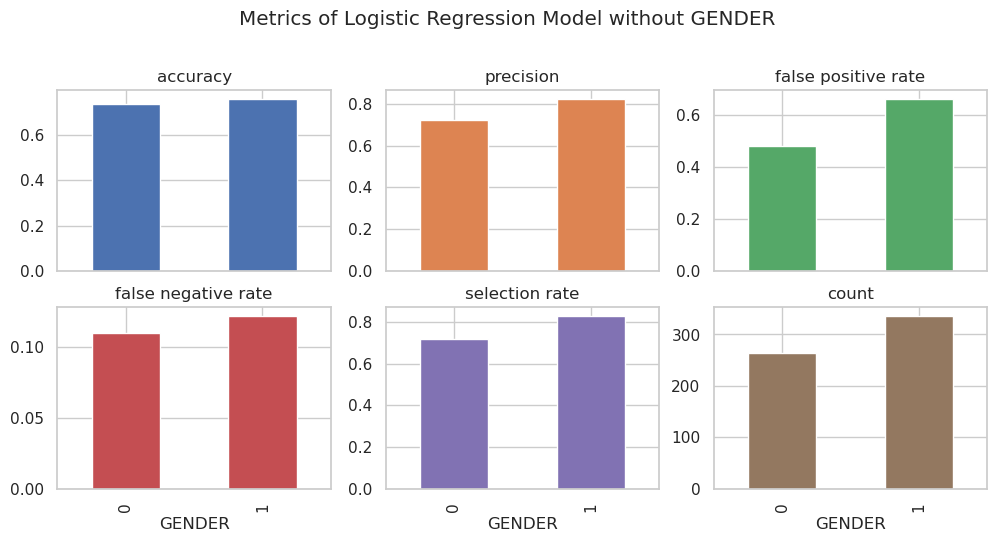

In [92]:
# Generate MetricFrame
metric_frame_lr_ng.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Metrics of Logistic Regression Model without GENDER",
)

By contrast, the model excluding gender information reveals significantly reduced false negative rates for males, whereas the disparities in false positive rates and selection rates are substantially attenuated.

#### 4.1.3 Logistic Regression with Correlation Remover

In [93]:
## MetricFrame
metric_frame_lr_cr = MetricFrame(
    metrics=equalErrMetrics, y_true=y_test, y_pred=y_pred_lr_cr, sensitive_features=X_test.GENDER
)

array([[<Axes: title={'center': 'accuracy'}, xlabel='GENDER'>,
        <Axes: title={'center': 'precision'}, xlabel='GENDER'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='GENDER'>],
       [<Axes: title={'center': 'false negative rate'}, xlabel='GENDER'>,
        <Axes: title={'center': 'selection rate'}, xlabel='GENDER'>,
        <Axes: title={'center': 'count'}, xlabel='GENDER'>],
       [<Axes: xlabel='GENDER'>, <Axes: xlabel='GENDER'>,
        <Axes: xlabel='GENDER'>]], dtype=object)

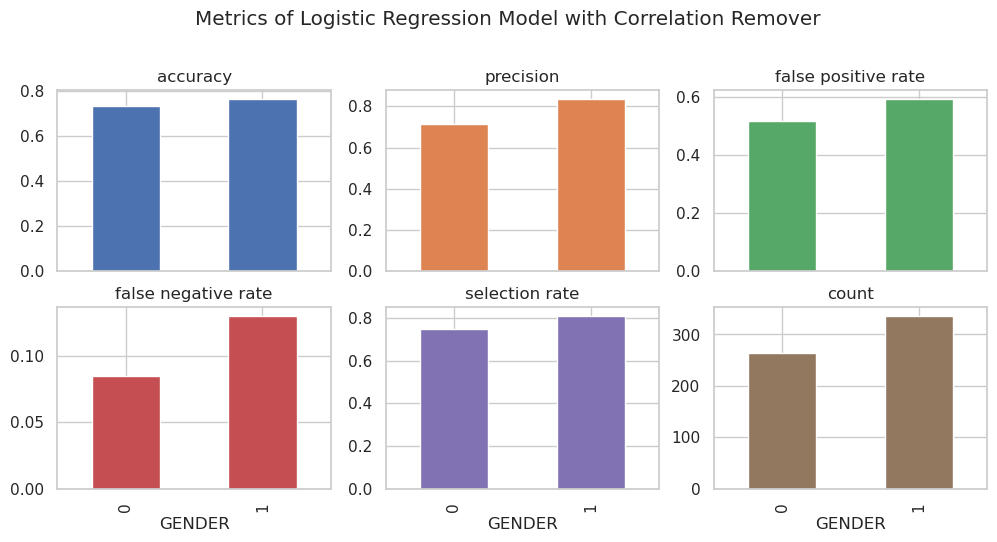

In [94]:
# Generate MetricFrame
metric_frame_lr_cr.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Metrics of Logistic Regression Model with Correlation Remover",
)

The model incorporating a correlation remover exhibits similar disparities in false rates between males and females as seen in the model excluding gender information. Specifically, females experience elevated false negative rate compared to males, while females remain attenuated disparities in false positive rates and selection rates.

### 4.2 Model Comparison with Plots of Metrics

At times, it is advantageous to compare and select models based on specific metrics. The `plot_model_comparison` function enables this process.

No matplotlib.Axes object was provided to draw on, so we create a new one
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


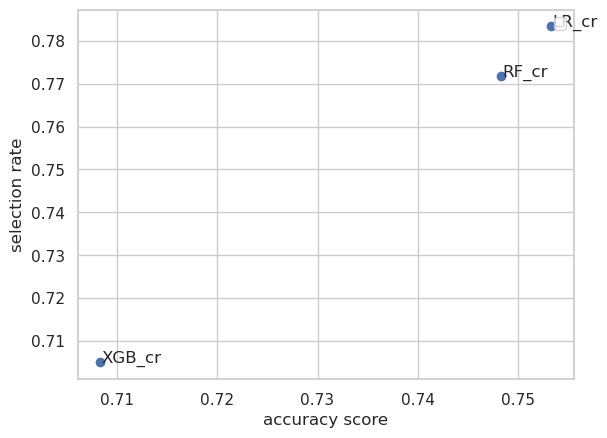

<Axes: xlabel='accuracy score', ylabel='selection rate'>

In [95]:
# Accuracy and Selection Rate
plot_model_comparison(y_preds={"XGB_cr": y_pred_xgb_cr, "LR_cr": y_pred_lr_cr, "RF_cr": y_pred_rf_cr}, 
                      y_true=y_test, 
                      sensitive_features=X_test.GENDER, 
                      x_axis_metric=accuracy_score, 
                      y_axis_metric=selection_rate, 
                      axis_labels=True, 
                      point_labels=['XGB_cr', 'LR_cr', 'RF_cr'],
                      point_labels_position=(0.0001, 0.0001),
                      legend=True, 
                      show_plot=True)

The plot illustrates a notable difference in performance among the three models. Specifically, it is evident that both Logistic Regression and Random Forest models exhibit superior accuracy scores and selection rates compared to the XGBoost model. Notably, the Logistic Regression model achieves slight superiority in both metrics.

No matplotlib.Axes object was provided to draw on, so we create a new one
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


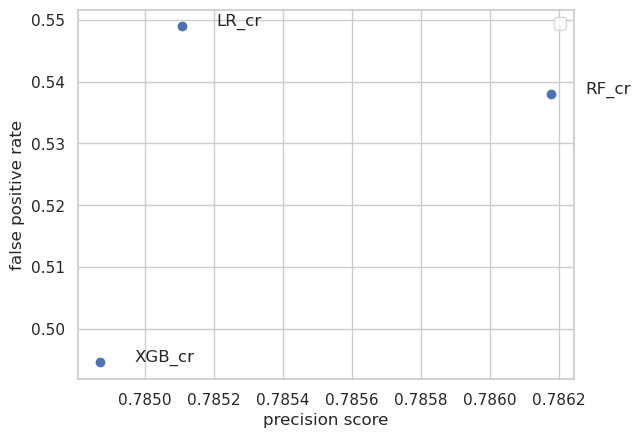

<Axes: xlabel='precision score', ylabel='false positive rate'>

In [96]:
# Precision and False Positive Rate
plot_model_comparison(y_preds={"XGB_cr": y_pred_xgb_cr, "LR_cr": y_pred_lr_cr, "RF_cr": y_pred_rf_cr}, 
                      y_true=y_test, 
                      sensitive_features=X_test.GENDER, 
                      x_axis_metric=precision_score, 
                      y_axis_metric=false_positive_rate, 
                      axis_labels=True, 
                      point_labels=['XGB_cr', 'LR_cr', 'RF_cr'],
                      point_labels_position=(0.0001, 0.0001),
                      legend=True, 
                      show_plot=True)

Interestingly, this plot reveals that the XGBoost model exhibits the lowest false positive rate among the three models. Furthermore, it is observed that the Random Forest model achieves higher precision scores while maintaining lower false positive rates than the logistic regression model.

---

## 5. Fairness Metrics

To further evaluate the performance of our constructed models, we propose applying various fairness metrics like Demographic Parity Difference and Equalized Odds to each model and comparing their results. This comparison will enable us to assess the relative merits of each model from the perspective of fairness.

### 5.1 Demographic Parity and Equalized Odds with GENDER

#### 5.1.1 XGBoost with GENDER

In [97]:
## Demographic Parity Difference of XGBoost Model with GENDER
dp_diff_xgb = demographic_parity_difference(y_true=y_test, 
                                            y_pred=y_pred_xgb,
                                            sensitive_features=X_test.GENDER)
print(f"Demographic Parity Difference of XGBoost Model with GENDER: {dp_diff_xgb}")

Demographic Parity Difference of XGBoost Model with GENDER: 0.25757575757575757


In [98]:
## Equalized Odds Difference of XGBoost Model with GENDER
eo_diff_xgb = equalized_odds_difference(y_true=y_test, 
                                        y_pred=y_pred_xgb,
                                        sensitive_features=X_test.GENDER)
print(f"Equalized Odds Difference of XGBoost Model with GENDER: {eo_diff_xgb}")

Equalized Odds Difference of XGBoost Model with GENDER: 0.40245700245700244


#### 5.1.2 Logistic Regression with GENDER

In [99]:
## Demographic Parity Difference of Logistic Regression Model with GENDER
dp_diff_lr = demographic_parity_difference(y_true=y_test, 
                                           y_pred=y_pred_lr,
                                           sensitive_features=X_test.GENDER)
print(f"Demographic Parity Difference of Logistic Regression with GENDER: {dp_diff_lr}")

Demographic Parity Difference of Logistic Regression with GENDER: 0.2724567099567099


In [100]:
## Equalized Odds Difference of Logistic Regression Model with GENDER
eo_diff_lr = equalized_odds_difference(y_true=y_test, 
                                       y_pred=y_pred_lr,
                                       sensitive_features=X_test.GENDER)
print(f"Equalized odds Difference of Logistic Regression with GENDER: {eo_diff_lr}")

Equalized odds Difference of Logistic Regression with GENDER: 0.4339066339066339


#### 5.1.3 Random Forest with GENDER

In [101]:
## Demographic Parity Difference of Random Forest Model with GENDER
dp_diff_rf = demographic_parity_difference(y_true=y_test, 
                                           y_pred=y_pred_rf,
                                           sensitive_features=X_test.GENDER)
print(f"Demographic Parity Difference of Random Forest with GENDER: {dp_diff_rf}")

Demographic Parity Difference of Random Forest with GENDER: 0.2678571428571429


In [102]:
## Equalized Odds Difference of Random Forest Model with GENDER
eo_diff_rf = equalized_odds_difference(y_true=y_test, 
                                       y_pred=y_pred_rf,
                                       sensitive_features=X_test.GENDER)
print(f"Equalized Odds Difference of Random Forest with GENDER: {eo_diff_rf}")

Equalized Odds Difference of Random Forest with GENDER: 0.3523341523341523


### 5.2 Demographic Parity and Equalized Odds without GENDER

#### 5.2.1 XGBoost without GENDER

In [103]:
## Demographic Parity Difference of XGBoost Model without GENDER
dp_diff_xgb_ng = demographic_parity_difference(y_true=y_test, 
                                               y_pred=y_pred_xgb_ng,
                                               sensitive_features=X_test.GENDER)
print(f"Demographic Parity Difference of XGBoost Model without GENDER: {dp_diff_xgb_ng}")

Demographic Parity Difference of XGBoost Model without GENDER: 0.0846861471861472


In [104]:
## Equalized Odds Difference of XGBoost Model without GENDER
eo_diff_xgb_ng = equalized_odds_difference(y_true=y_test, 
                                           y_pred=y_pred_xgb_ng,
                                           sensitive_features=X_test.GENDER)
print(f"Equalized Odds Difference of XGBoost Model without GENDER: {eo_diff_xgb_ng}")

Equalized Odds Difference of XGBoost Model without GENDER: 0.16265356265356268


#### 5.2.2 Logistic Regression without GENDER

In [105]:
## Demographic Parity Difference of Logistic Regression Model without GENDER
dp_diff_lr_ng = demographic_parity_difference(y_true=y_test, 
                                              y_pred=y_pred_lr_ng,
                                              sensitive_features=X_test.GENDER)
print(f"Demographic Parity Difference of Logistic Regression without GENDER: {dp_diff_lr_ng}")

Demographic Parity Difference of Logistic Regression without GENDER: 0.11066017316017318


In [106]:
## Equalized Odds Difference of Logistic Regression Model without GENDER
eo_diff_lr_ng = equalized_odds_difference(y_true=y_test, 
                                          y_pred=y_pred_lr_ng,
                                          sensitive_features=X_test.GENDER)
print(f"Equalized odds Difference of Logistic Regression without GENDER: {eo_diff_lr_ng}")

Equalized odds Difference of Logistic Regression without GENDER: 0.18034398034398036


#### 5.2.3 Random Forest without GENDER

In [107]:
## Demographic Parity Difference of Random Forest Model without GENDER
dp_diff_rf_ng = demographic_parity_difference(y_true=y_test, 
                                              y_pred=y_pred_rf_ng,
                                              sensitive_features=X_test.GENDER)
print(f"Demographic Parity Difference of Random Forest without GENDER: {dp_diff_rf_ng}")

Demographic Parity Difference of Random Forest without GENDER: 0.09090909090909083


In [108]:
## Equalized Odds Difference of Random Forest Model without GENDER
eo_diff_rf_ng = equalized_odds_difference(y_true=y_test, 
                                          y_pred=y_pred_rf_ng,
                                          sensitive_features=X_test.GENDER)
print(f"Equalized Odds Difference of Random Forest without GENDER: {eo_diff_rf_ng}")

Equalized Odds Difference of Random Forest without GENDER: 0.1262899262899263


### 5.3 Demographic Parity and Equalized Odds with Correlation Remover

#### 5.3.1 XGBoost with Correlation Remover

In [109]:
## Demographic Parity Difference of XGBoost Model with Correlation Remover
dp_diff_xgb_cr = demographic_parity_difference(y_true=y_test, 
                                               y_pred=y_pred_xgb_cr,
                                               sensitive_features=X_test.GENDER)
print(f"Demographic Parity Difference of XGBoost Model with Correlation Remover: {dp_diff_xgb_cr}")

Demographic Parity Difference of XGBoost Model with Correlation Remover: 0.23079004329004327


In [110]:
## Equalized Odds Difference of XGBoost Model with Correlation Remover
eo_diff_xgb_cr = equalized_odds_difference(y_true=y_test, 
                                           y_pred=y_pred_xgb_cr,
                                           sensitive_features=X_test.GENDER)
print(f"Equalized Odds Difference of XGBoost Model with Correlation Remover: {eo_diff_xgb_cr}")

Equalized Odds Difference of XGBoost Model with Correlation Remover: 0.3029484029484029


#### 5.3.2 Logistic Regression mit Correlation Remover

In [111]:
## Demographic Parity Difference of Logistic Regression with Correlation Remover
dp_diff_lr_cr = demographic_parity_difference(y_true=y_test, 
                                              y_pred=y_pred_lr_cr,
                                              sensitive_features=X_test.GENDER)
print(f"Demographic Parity Difference of Logistic Regression with Correlation Remover: {dp_diff_lr_cr}")

Demographic Parity Difference of Logistic Regression with Correlation Remover: 0.059523809523809534


In [112]:
## Equalized Odds Difference of Logistic Regression with Correlation Remover
eo_diff_lr_cr = equalized_odds_difference(y_true=y_test, 
                                          y_pred=y_pred_lr_cr,
                                          sensitive_features=X_test.GENDER)
print(f"Equalized Odds Difference of Logistic Regression with Correlation Remover: {eo_diff_lr_cr}")

Equalized Odds Difference of Logistic Regression with Correlation Remover: 0.07641277641277644


#### 5.3.3 Random Forest with Correlation Remover

In [113]:
## Demographic Parity Difference of Random Forest with Correlation Remover
dp_diff_rf_cr = demographic_parity_difference(y_true=y_test, 
                                              y_pred=y_pred_rf_cr,
                                              sensitive_features=X_test.GENDER)
print(f"Demographic Parity Difference of Random Forest with Correlation Remover: {dp_diff_rf_cr}")

Demographic Parity Difference of Random Forest with Correlation Remover: 0.2821969696969697


In [114]:
## Equalized Odds Difference of Random Forest with Correlation Remover
eo_diff_rf_cr = equalized_odds_difference(y_true=y_test, 
                                          y_pred=y_pred_rf_cr,
                                          sensitive_features=X_test.GENDER)
print(f"Equalized Odds Difference of Random Forest with Correlation Remover: {eo_diff_rf_cr}")

Equalized Odds Difference of Random Forest with Correlation Remover: 0.38845208845208845


### 5.4 Comparison of Fairness Metrics for all models

In [115]:
# Fairness Metrics Table for all Models
df_Fairtable_sum = pd.DataFrame()
df_Fairtable_sum['Model'] = ['XGB','XGB_ng','XGB_cr', 'LR','LR_ng','LR_cr', 'RF', 'RF_ng', 'RF_cr']
df_Fairtable_sum['Demographic Parity Difference'] = [dp_diff_xgb, dp_diff_xgb_ng, dp_diff_xgb_cr, \
                                                     dp_diff_lr, dp_diff_lr_ng, dp_diff_lr_cr, \
                                                     dp_diff_rf, dp_diff_rf_ng, dp_diff_rf_cr]
df_Fairtable_sum['Equalized Odds Difference'] = [eo_diff_xgb, eo_diff_xgb_ng, eo_diff_xgb_cr, \
                                                 eo_diff_lr, eo_diff_lr_ng, eo_diff_lr_cr, \
                                                 eo_diff_rf, eo_diff_rf_ng, eo_diff_rf_cr]
df_Fairtable_sum.set_index("Model", inplace = True)
df_Fairtable_sum

,Demographic Parity Difference,Equalized Odds Difference
Model,,
XGB,0.257576,0.402457
XGB_ng,0.084686,0.162654
XGB_cr,0.230790,0.302948
LR,0.272457,0.433907
LR_ng,0.110660,0.180344
LR_cr,0.059524,0.076413
RF,0.267857,0.352334
RF_ng,0.090909,0.126290
RF_cr,0.282197,0.388452


##### Observations:

- Upon removing the protected variable GENDER, we observe significant reductions in both Demographic Parity Difference and Equalized Odds Difference. These findings suggest that the removal of this variable has effectively mitigated gender bias within these models, resulting in improved fairness.

- The XGBoost model incorporating a Correlation Remover exhibits reduced Demographic Parity Difference and Equalized Odds Difference compared to the reference model, suggesting a reduction in bias. However, the values are much higer than that of the model without the protected variable GENDER and the gain in fairness is accompanied by a corresponding decrease in all performance metrics except the AUC.

- The Logistic Regression model with Correlation Remover demonstrates a more pronounced reduction in Demographic Parity Difference and Equalized Odds Difference compared to the model without the protected variable GENDER. This gain in fairness metrics is particularly noteworthy, as it occurs without compromising the model's performance relative to the reference model.

- Contrary to our expectations, the Random Forest model with Correlation Remover exhibits an increase in Demographic Parity Difference and Equalized Odds Difference relative to the reference model. This outcome suggests that the incorporation of a Correlation Remover has not contributed to a reduction in bias.

---

## 6. Conclusion

This notebook presents an analysis of three machine learning models (XGBoost, Logistic Regression, and Random Forest) applied to the Health Expenditures dataset for classification purposes. The investigation considered three scenarios: one involving the inclusion of GENDER as a protected variable, one without GENDER, and another with application of a correlation remover, with a view to exploring the effects of these different approaches on model performance and fairness characteristics.

Subsequent to model development, we conducted an comparative analysis of performance metrics (Accuracy, Precision, Recall, and AUC) and fairness metrics (Demographic Parity Difference and Equalized Odds Difference) across our models. Notably, while models that eliminated the protected variable GENDER were found to significantly reduce bias, this reduction came at the cost of decreased performance metric values. 

The Correlation Remover offers a preprocessing tool for addressing bias with respect to protected variables. Nevertheless, its application does not provide a guarantee of improved fairness metrics. In our Logistic Regression model, the correlation remover has been demonstrated to yield reduced fairness metrics compared to those without the protected variable; however, this improvement is less pronounced in other models. Notably, our XGBoost model exhibits only modest reductions in fairness metrics, whereas our Random Forest model experiences an increase in Demographic Parity Difference and Equalized Odds Difference relative to the reference model, thereby compounding bias.

Through the use of MetricFrame visualizations and comparative plots, practitioners can select models tailored to their specific goals. This notebook serves as a resource for providing examples and tools to facilitate exploration of additional metrics, methodologies and approaches.